# Project Pipeline: Integrating Gene Data with MOFA

This document outlines a complete, start-to-finish project pipeline for integrating and analyzing your four binary gene datasets (GO-BP, GO-MF, GO-CC, and HPO) using Multi-Omics Factor Analysis (MOFA).

---

### **Phase 1: Data Pre-processing & Setup**

The goal of this phase is to load your four datasets and ensure they are perfectly formatted for MOFA.

1.  **Load Data:** Load your four `.csv` files (e.g., using the `pandas` library in Python) into four separate data frames.
2.  **Inspect Data:** Confirm that in each matrix, **rows are genes** and **columns are terms** (GO or HPO terms).
3.  **Feature Filtering (Column Selection):**
    - **Goal:** Remove "shallow" or generic terms (e.g., "biological process") that don't provide specific information.
    - **Action:** Use the `goterm_depth` files. Filter out any columns (GO terms) where the depth is less than 4.
    - **Result:** A cleaner dataset with reduced noise and faster training times.
4.  **Align Samples (Critical Step):** MOFA requires the samples (genes) to be in the _exact same order_ across all four matrices.
    - Find the set of genes that are common to _all four_ of your files.
    - Filter all four matrices to keep _only_ this common set of genes.
    - Re-order the rows in all four matrices so that `gene_A`, `gene_B`, `gene_C`, etc., are in the identical order in each one.
5.  **Format for MOFA:**
    - Ensure all data is numeric (0s and 1s).
    - Create a single Python `list` containing your four data frames (or NumPy arrays). For example: `views_data = [df_bp, df_mf, df_cc, df_hpo]`

---

### **Phase 2: MOFA Model Training**

Now you will build and run the MOFA model.

1.  **Initialize MOFA Model:** Import and initialize the MOFA model (e.g., `from mofapy2.run.entry_point import mofa_entry_point`).
2.  **Set Key Parameters:**
    - `data`: The `views_data` list you created in Phase 1.
    - `n_factors`: Set the number of factors to discover. Your instructor noted "often no more than 15," so `15` or `20` is a good starting point. MOFA will prune unused factors.
    - **`likelihoods` (The "Interesting Feature"):** This is the most important parameter for your specific project. Because your data is binary (0s and 1s), you must tell MOFA to use the "Bernoulli" likelihood.
      - Set this parameter to: `likelihoods = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']` (one for each of your four views).
3.  **Train the Model:** Run the MOFA training. This will generate the latent factors.
4.  **Save the Model:** Save the trained model to a file (e.g., `.hdf5`). This allows you to reload it for analysis without re-running the time-consuming training.

---

### **Phase 3: Model Diagnostics & Factor Analysis**

This is the core MOFA output. You will now investigate what the model has learned, directly addressing your instructor's suggestion to see how factors relate to the original data.

1.  **Analyze Variance Decomposition:**
    - This is the **most important plot** in MOFA.
    - **Action:** Generate the "variance explained" heatmap.
    - **How to Read It:**
      - The heatmap shows _Factors_ (e.g., Factor 1, Factor 2...) on the Y-axis and your _Views_ (BP, MF, CC, HPO) on the X-axis.
      - A bright cell means a factor explains a lot of the variation in that specific view.
    - **Look For:**
      - **Shared Factors:** A factor that is bright for _all four_ views. This represents a core biological process that involves all four aspects.
      - **View-Specific Factors:** A factor that is bright _only_ for HPO (a "symptom-only" factor) or _only_ for GO-CC (a "cellular location" factor).
2.  **Visualize the Latent Space:**
    - **Action:** Extract the latent factors for all genes. This is your new, integrated dataset (e.g., `Genes x 15 Factors`).
    - **Action:** Make a scatter plot of Factor 1 vs. Factor 2. Each point on this plot is a single gene, placed according to its value for these two factors. This is your first look at the integrated "map" of your genes.

---

### **Phase 4: Downstream Analysis (Clustering & Interpretation)**

Now you will "do something" with the integrated data, as your instructor suggested.

1.  **Clustering (As per Assignment):**

    - **Action:** Use the new latent factor matrix (Genes x Factors) as input for a clustering algorithm.
    - **Methods:**
      - **Spectral Clustering** (as suggested).
      - **K-Means** (a simple, fast alternative).
      - **HDBscan** (a modern algorithm that can find clusters of different shapes and handle "noise").
    - **Action:** Get your cluster assignments (e.g., Cluster 1, Cluster 2, etc.) for each gene.
    - **Action:** Re-plot your Factor 1 vs. Factor 2 scatter plot, but now **color the points by their cluster ID**. You will immediately see if your clusters are well-defined.

2.  **"Interesting Feature": Interpreting Factor & Cluster Biology**
    - This is the key to a great project. We will find out what the factors _mean_.
    - **Action:** Extract the **weights** from the MOFA model. The weights show which _original features_ (i.e., which specific GO/HPO terms) are driving each factor.
    - **Interpretation Example:**
      1.  You see from Phase 3 that **Factor 1** explains variance in **HPO** and **GO-BP**.
      2.  You extract the **top 10 weights** for Factor 1.
      3.  From the **HPO view**, the top terms are "Abnormality of the cardiovascular system" and "Arrhythmia".
      4.  From the **GO-BP view**, the top terms are "cardiac muscle cell development" and "heart morphogenesis".
      5.  **Conclusion:** You can confidently label **Factor 1** as the **"Cardiac Biology" factor**. If Cluster 1 is highly associated with Factor 1, you can label it the "Cardiac Gene Cluster."

---

### **Phase 5: External Validation**

This feature makes your project more robust by proving your clusters are biologically meaningful using an external, unbiased tool.

1.  **"Interesting Feature": Gene Set Enrichment Analysis (GSEA)**
    - **Action:** Choose one of your new clusters (e.g., your "Cardiac Gene Cluster" from Phase 4). Copy the list of all genes in that cluster.
    - **Tool:** Go to the **g:Profiler** website (a popular, free web tool for GSEA).
    - **Action:** Paste your gene list into the g:Profiler query box and run the analysis.
2.  **Analyze g:Profiler Results:**
    - g:Profiler will return a list of biological pathways (e.g., from databases like KEGG, Reactome) that are statistically over-represented in your gene list.
    - If your "Cardiac Gene Cluster" list returns pathways like "KEGG: Cardiac Muscle Contraction" (p-value < 0.001), you have **externally validated** that your MOFA-derived cluster is a real, coherent biological module.


#### Imports


In [1]:
import pandas as pd
import numpy as np
from mofapy2.run.entry_point import entry_point
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


### **Phase 1: Data Pre-processing & Setup**

In [3]:
def filter_by_depth(df_gene_matrix, depth_file_path, min_depth=4):
    
    try:
        # Load the depth file. 
        df_depth = pd.read_csv(depth_file_path, index_col=0, nrows=1)
        
        depth_series = df_depth.iloc[0]
        depth_series = pd.to_numeric(depth_series, errors='coerce')
        depth_series = depth_series.dropna()
        # Identify terms to keep
        terms_to_keep = depth_series[depth_series >= min_depth].index.tolist()
        
        # Filter the main matrix columns
        common_cols = [c for c in df_gene_matrix.columns if c in terms_to_keep]
        df_filtered = df_gene_matrix[common_cols]
        
        return df_filtered
    except Exception as e:
        print(f"Error filtering by depth: {e}")
        return df_gene_matrix

def load_align_and_filter_data(file_paths, depth_paths, output_file_paths):
    
    #Load Data
    df_bp = pd.read_csv(file_paths['BP'], index_col=0)
    df_cc = pd.read_csv(file_paths['CC'], index_col=0)
    df_mf = pd.read_csv(file_paths['MF'], index_col=0)
    df_hpo = pd.read_csv(file_paths['HPO'], index_col=0)
    
    #Filter by Depth
    df_bp = filter_by_depth(df_bp, depth_paths['BP'], min_depth=4)
    df_cc = filter_by_depth(df_cc, depth_paths['CC'], min_depth=4)  
    df_mf = filter_by_depth(df_mf, depth_paths['MF'], min_depth=4)

    #Align Samples
    common_genes = set(df_bp.index)
    common_genes.intersection_update(df_cc.index)
    common_genes.intersection_update(df_mf.index)
    common_genes.intersection_update(df_hpo.index)
    
    common_genes = sorted(list(common_genes))
    
    # Reindex all dataframes
    df_bp = df_bp.reindex(common_genes)
    df_cc = df_cc.reindex(common_genes)
    df_mf = df_mf.reindex(common_genes)
    df_hpo = df_hpo.reindex(common_genes)

    df_bp.to_csv(output_file_paths['BP'])
    df_cc.to_csv(output_file_paths['CC'])
    df_mf.to_csv(output_file_paths['MF'])
    df_hpo.to_csv(output_file_paths['HPO'])
    return [df_bp, df_cc, df_mf, df_hpo], common_genes

In [4]:
data_files = {
    "BP": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv",
    "HPO": "./csv_data/gene_hpo_matrix_binary_withAncestors_namespace_Phenotypic_abnormality.csv"
}
    
depth_files = {
    "BP": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-MF.csv"
}

output_files = {
    "BP": "processed_BP.csv",
    "CC": "processed_CC.csv",
    "MF": "processed_MF.csv",
    "HPO": "processed_HPO.csv"
}

mofa_views, common_genes = load_align_and_filter_data(data_files, depth_files, output_files)

Pre-Filtering Dimensions <br> 
(5183, 9873) <br>
(5183, 1478)<br>
(5183, 3258)<br>
(5183, 10185)<br>

In [5]:
print(mofa_views[0].shape)
print(mofa_views[1].shape)
print(mofa_views[2].shape)
print(mofa_views[3].shape)

(5183, 8624)
(5183, 760)
(5183, 2635)
(5183, 10185)


### **Phase 2: MOFA Model Training**

In [2]:
output_files = {
    "BP": "processed_BP.csv",
    "CC": "processed_CC.csv",
    "MF": "processed_MF.csv",
    "HPO": "processed_HPO.csv"
}

mofa_views = [pd.read_csv(output_files[key], index_col=0) for key in ["BP", "CC", "MF", "HPO"]]

In [3]:
print([df.shape for df in mofa_views])

[(5183, 8624), (5183, 760), (5183, 2635), (5183, 10185)]


In [6]:
# 1. Initialization
me = entry_point()

# Data preparation
LIKELIHOODS = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']
# The data is nested: [[df_bp], [df_cc], [df_mf], [df_hpo]] to define 4 views with 1 group each.
mofa_views_nested = [[df] for df in mofa_views] 

# 2. Set Data Pre-processing Options (Scaling/Centering)
me.set_data_options(
    scale_views=False,
    scale_groups=False,
    center_groups=True,
    use_float32=False
)

# 3. Set Data and Likelihoods
me.set_data_matrix(
    data=mofa_views_nested,
    likelihoods=LIKELIHOODS,
    views_names=['GO-BP', 'GO-CC', 'GO-MF', 'HPO']
)

# 4. Set Model Parameters
N_FACTORS = 10
me.set_model_options(
    factors=N_FACTORS,
    spikeslab_weights=True,
    ard_weights=True
)




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='GO-BP' group='group0' with N=5183 sa

In [8]:
# 5. Set Training and Output Options
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\Scientific_Visualization\\Second_assignment_project\\ScientificVisualization\\mofa_model.hdf5"

me.set_train_options(
    iter=1000, 
    convergence_mode="fast", 
    gpu_mode=True, #False if no GPU available
    seed=42,
    outfile=MODEL_OUTPUT_FILE
)


me.build()
me.run()

me.save(MODEL_OUTPUT_FILE)


GPU mode is activated



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -200602642.84 

Iteration 1: time=8.39, ELBO=-107891942.94, deltaELBO=92710699.907 (46.21609097%), Factors=10
Iteration 2: time=8.42, ELBO=-79476406.06, deltaELBO=28415536.880 (14.16508600%), Factors=10
Iteration 3: time=8.14, ELBO=-79404283.87, deltaELBO=72122.186 (0.03595276%), Factors=10
Iteration 4: time=8.10, ELBO=-79387444.17, deltaELBO=16839.696 (0.00839455%), Factors=10
Iteration 5: time=8.04, ELBO=-79369487.85, deltaELBO=17956.327 (0.00895119%), Factors=10
Iteration 6: time=8.11, ELBO=-79350745.35, deltaELBO=18742.499 (0.00934310%), Factors=10
Iteration 7: time=8.02, ELBO=-79334075.95, deltaELBO=16669.395 (0.00830966%), Factors=10
Iteration 8: time=8.13, ELBO=-79319652.24, deltaELBO=14423.716 (0.00719019%), Factors=10
Iteration 9: time=8.02, ELBO=-79306874.81, deltaELBO=12777.428 (0.00636952%), Factors=10
Iteratio

### **Phase 3: Model Diagnostics & Factor Analysis**

This is the core MOFA output. You will now investigate what the model has learned, directly addressing your instructor's suggestion to see how factors relate to the original data.

1.  **Analyze Variance Decomposition:**
    - This is the **most important plot** in MOFA.
    - **Action:** Generate the "variance explained" heatmap.
    - **How to Read It:**
      - The heatmap shows _Factors_ (e.g., Factor 1, Factor 2...) on the Y-axis and your _Views_ (BP, MF, CC, HPO) on the X-axis.
      - A bright cell means a factor explains a lot of the variation in that specific view.
    - **Look For:**
      - **Shared Factors:** A factor that is bright for _all four_ views. This represents a core biological process that involves all four aspects.
      - **View-Specific Factors:** A factor that is bright _only_ for HPO (a "symptom-only" factor) or _only_ for GO-CC (a "cellular location" factor).
2.  **Visualize the Latent Space:**
    - **Action:** Extract the latent factors for all genes. This is your new, integrated dataset (e.g., `Genes x 15 Factors`).
    - **Action:** Make a scatter plot of Factor 1 vs. Factor 2. Each point on this plot is a single gene, placed according to its value for these two factors. This is your first look at the integrated "map" of your genes.

---

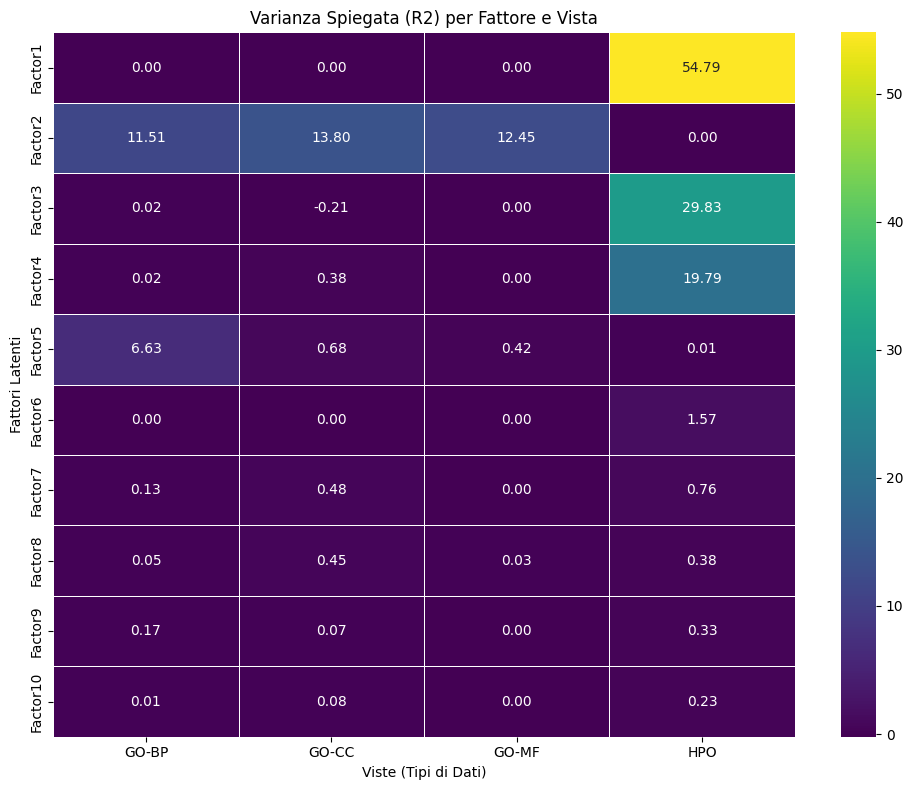

In [18]:
import mofax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model = mofax.mofa_model(MODEL_OUTPUT_FILE)

r2_df = model.get_variance_explained()

r2_matrix = r2_df.pivot(index='Factor', columns='View', values='R2')

sorted_index = sorted(r2_matrix.index, key=lambda x: int(x.replace("Factor", "")))
r2_matrix = r2_matrix.reindex(sorted_index)

plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix, 
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.title("Varianza Spiegata (R2) per Fattore e Vista")
plt.ylabel("Fattori Latenti")
plt.xlabel("Viste (Tipi di Dati)")
plt.tight_layout()
plt.show()

Dimensioni del modello: (5183, 10)
Nomi attuali (generici): ['sample0_group0', 'sample1_group0', 'sample2_group0']

Etichettando 29 geni outlier sul grafico...


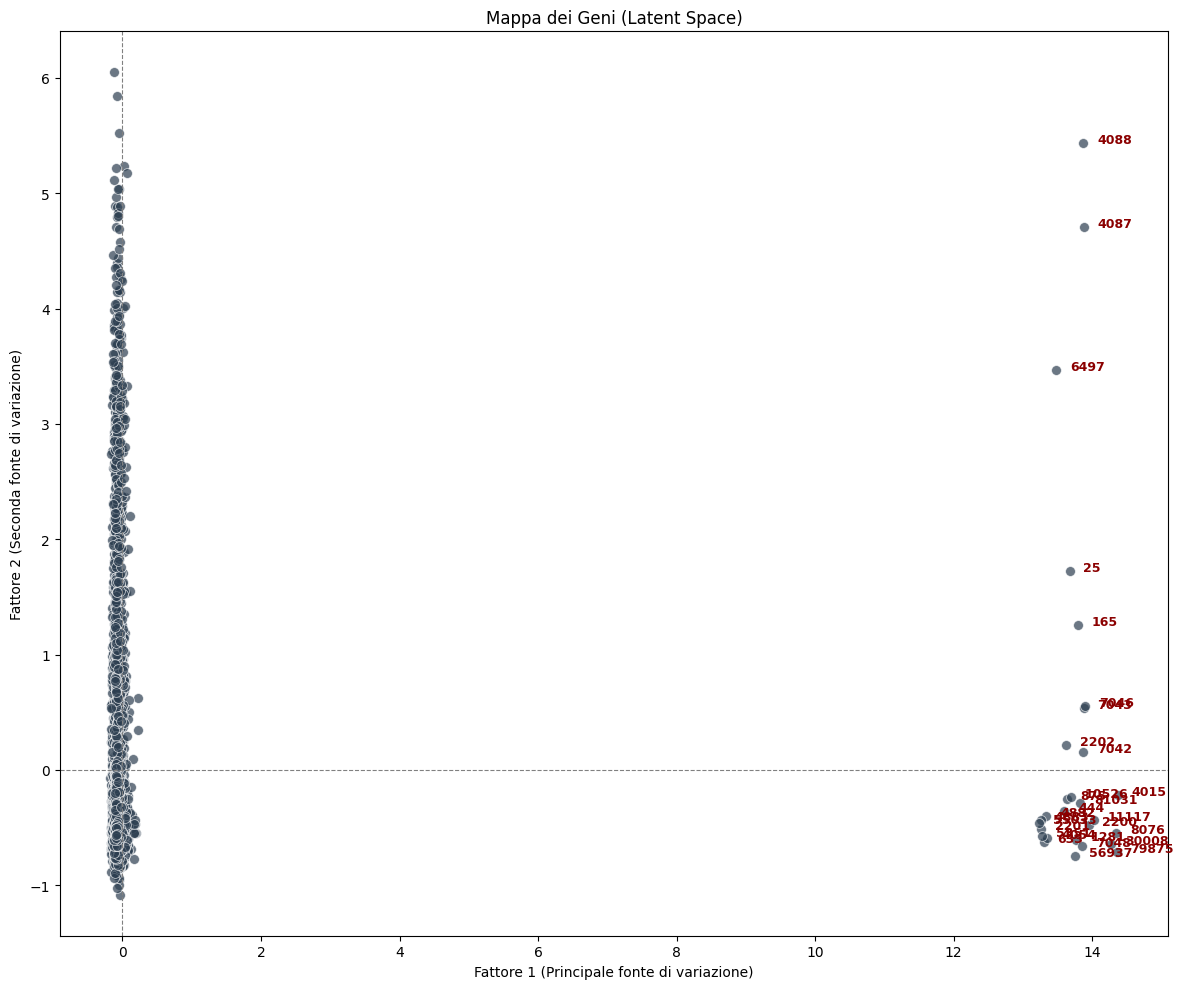


--- 🧬 LISTA DEI GENI NEL CLUSTER DI DESTRA ---
['25', '165', '444', '633', '875', '1281', '2200', '2201', '2202', '4015', '4054', '4087', '4088', '4882', '4883', '5351', '6497', '7042', '7043', '7046', '7048', '8076', '10526', '11117', '30008', '55033', '56937', '79875', '81031']


In [ ]:
import mofax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

factors_df = model.get_factors(df=True)

PATH_TO_BP_CSV = r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\processed_BP.csv"

try:
    true_gene_names = pd.read_csv(PATH_TO_BP_CSV, index_col=0).index.astype(str).tolist()
    
    factors_df.index = true_gene_names
except Exception as e:
    print(e)

plt.figure(figsize=(12, 10))

sns.scatterplot(
    data=factors_df,
    x="Factor1", 
    y="Factor2",
    alpha=0.7,
    s=50,
    color="#2c3e50"
)

plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

plt.title("Mappa dei Geni (Latent Space)")
plt.xlabel("Fattore 1 (Principale fonte di variazione)")
plt.ylabel("Fattore 2 (Seconda fonte di variazione)")

outliers = factors_df[factors_df["Factor1"] > 5]

print(f"\nEtichettando {len(outliers)} geni outlier sul grafico...")

for gene_name in outliers.index:
    plt.text(
        outliers.loc[gene_name, "Factor1"] + 0.2, 
        outliers.loc[gene_name, "Factor2"], 
        str(gene_name),
        fontsize=9,
        color='darkred',
        weight='bold'
    )

plt.tight_layout()
plt.show()

if len(outliers) > 0:
    print("\n--- 🧬 LISTA DEI GENI NEL CLUSTER DI DESTRA ---")
    print(outliers.index.tolist())

In [96]:
import mofax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests

# Load Model
MODEL_OUTPUT_FILE = r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\mofa_model_10.hdf5"
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

# File Paths Configuration
file_paths = {
    'GO-BP': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\processed_BP.csv",
    'GO-CC': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\processed_CC.csv", 
    'GO-MF': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\processed_MF.csv",
    'HPO':   r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\processed_HPO.csv"
}

def get_term_description(term_id):
    
    try:
        # Fetch GO Terms
        if term_id.startswith("GO."):
            term_id = term_id.replace(".", ":")
            url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{term_id}"
            response = requests.get(url, headers={"Accept": "application/json"}, timeout=2)
            if response.status_code == 200:
                return response.json()['results'][0]['name']
        
        # Fetch HPO Terms
        elif term_id.startswith("HP:"):
            url = f"https://ontology.jax.org/api/hp/terms/{term_id}"
            response = requests.get(url, timeout=2)
            if response.status_code == 200:
                return response.json()['name']
                
    except Exception:
        print(f"Error fetching description for {term_id}")
    
    return term_id

def plot_weights_fixed_translated(view_name, factor_index=0, n_top=15):
    
    
    # Load Weights
    try:
        w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
    except Exception as e:
        print(f"Error loading weights: {e}")
        return

    # Fix Feature Names from CSV
    try:
        if view_name in file_paths:
            csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
            
            if len(csv_cols) == len(w_df):
                w_df.index = csv_cols
            else:
                print(f"Warning: Column count mismatch for {view_name}. Using generic IDs.")
    except Exception as e:
        print(f"Error reading CSV: {e}")

    # Process & Sort Top Features
    col_name = None
    for c in w_df.columns:
        if pd.api.types.is_numeric_dtype(w_df[c]):
            col_name = c
            break     
    if col_name is None: return

    w_df['abs_val'] = w_df[col_name].abs()
    top_features = w_df.sort_values('abs_val', ascending=False).head(n_top)

    new_labels = [] 

    for term_id, row in top_features.iterrows():
        desc = get_term_description(term_id)
        weight_val = row[col_name]
        
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features.index = new_labels

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=top_features,
        x=col_name,
        y=top_features.index,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Features - {view_name} - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()


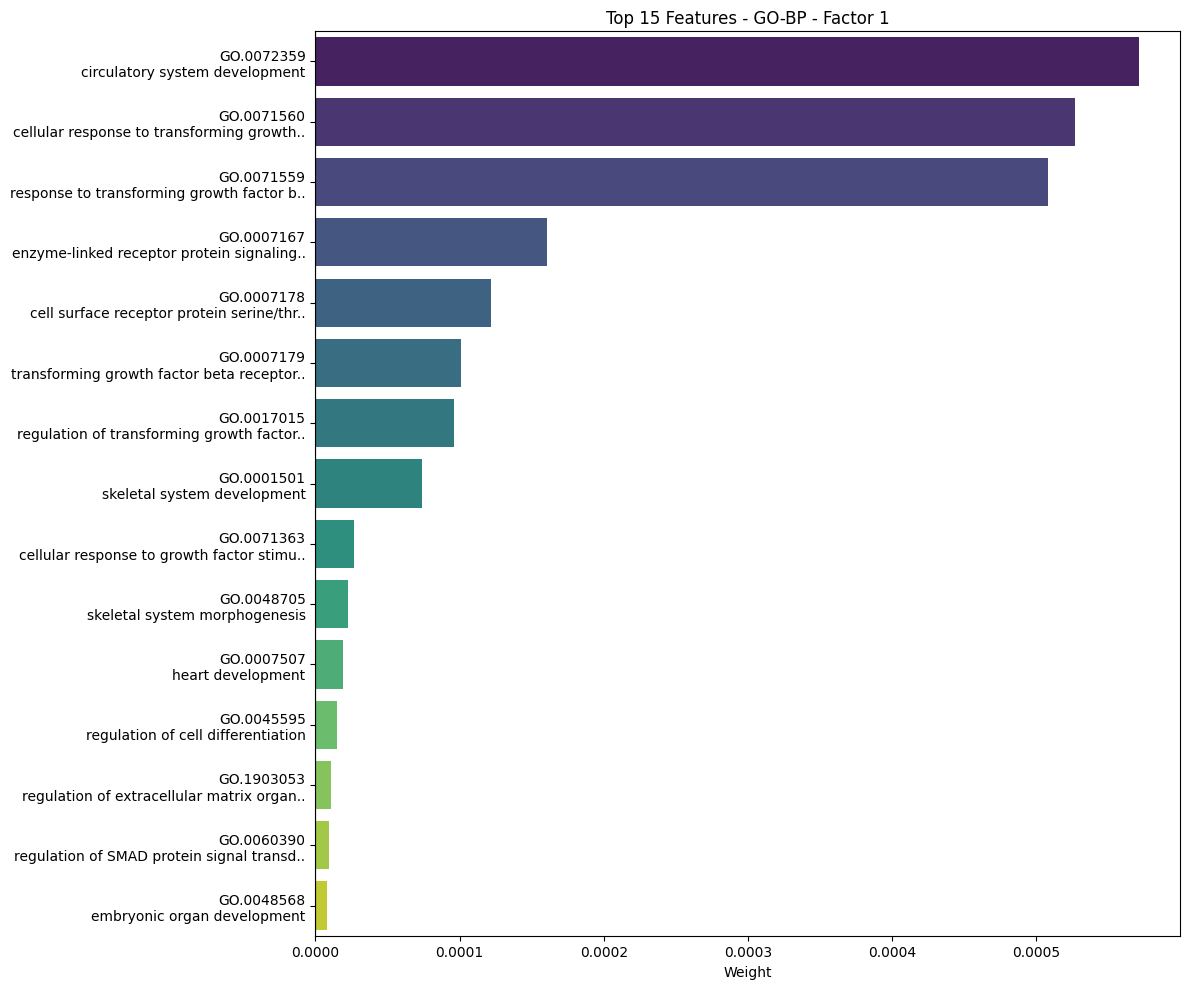

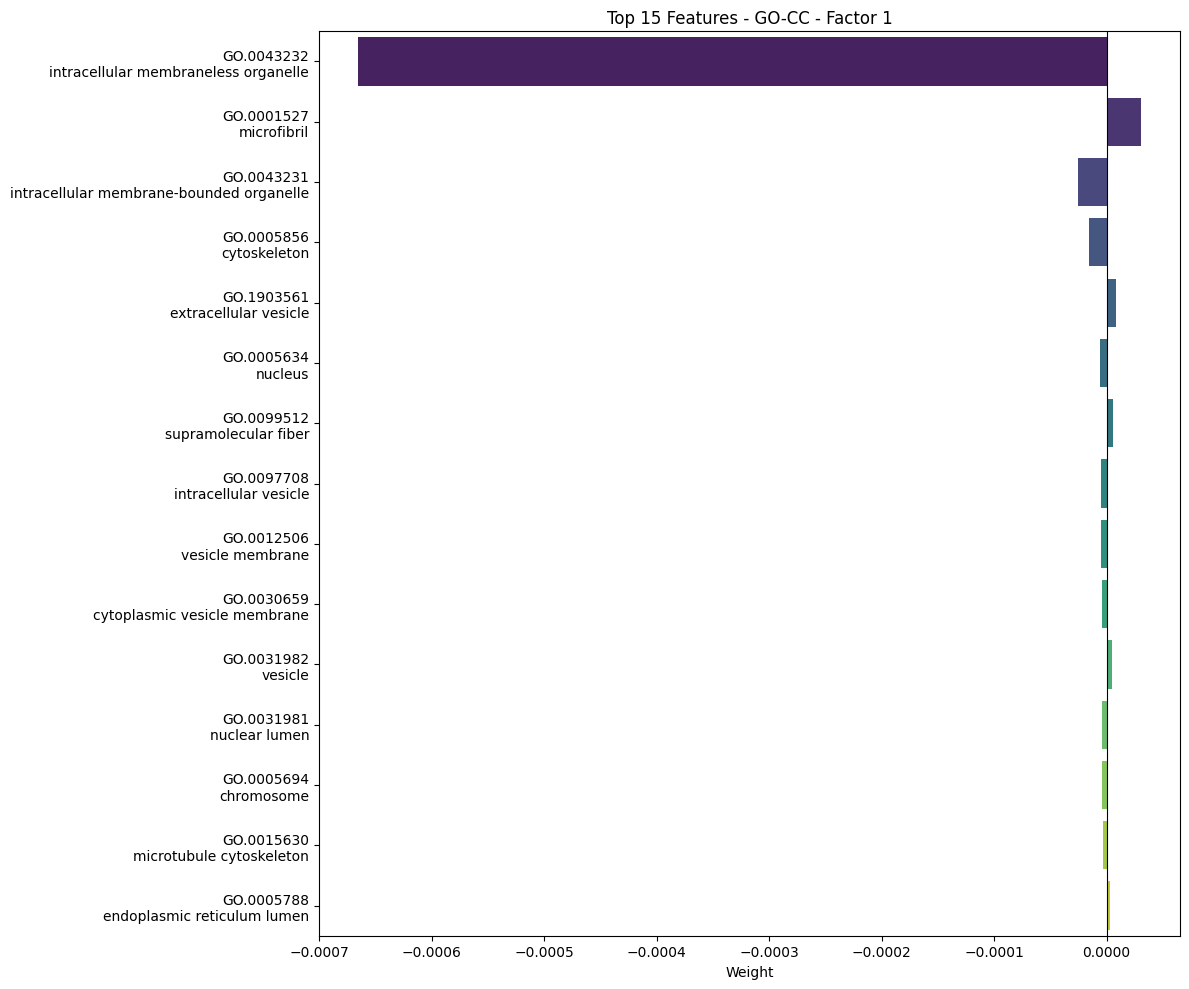

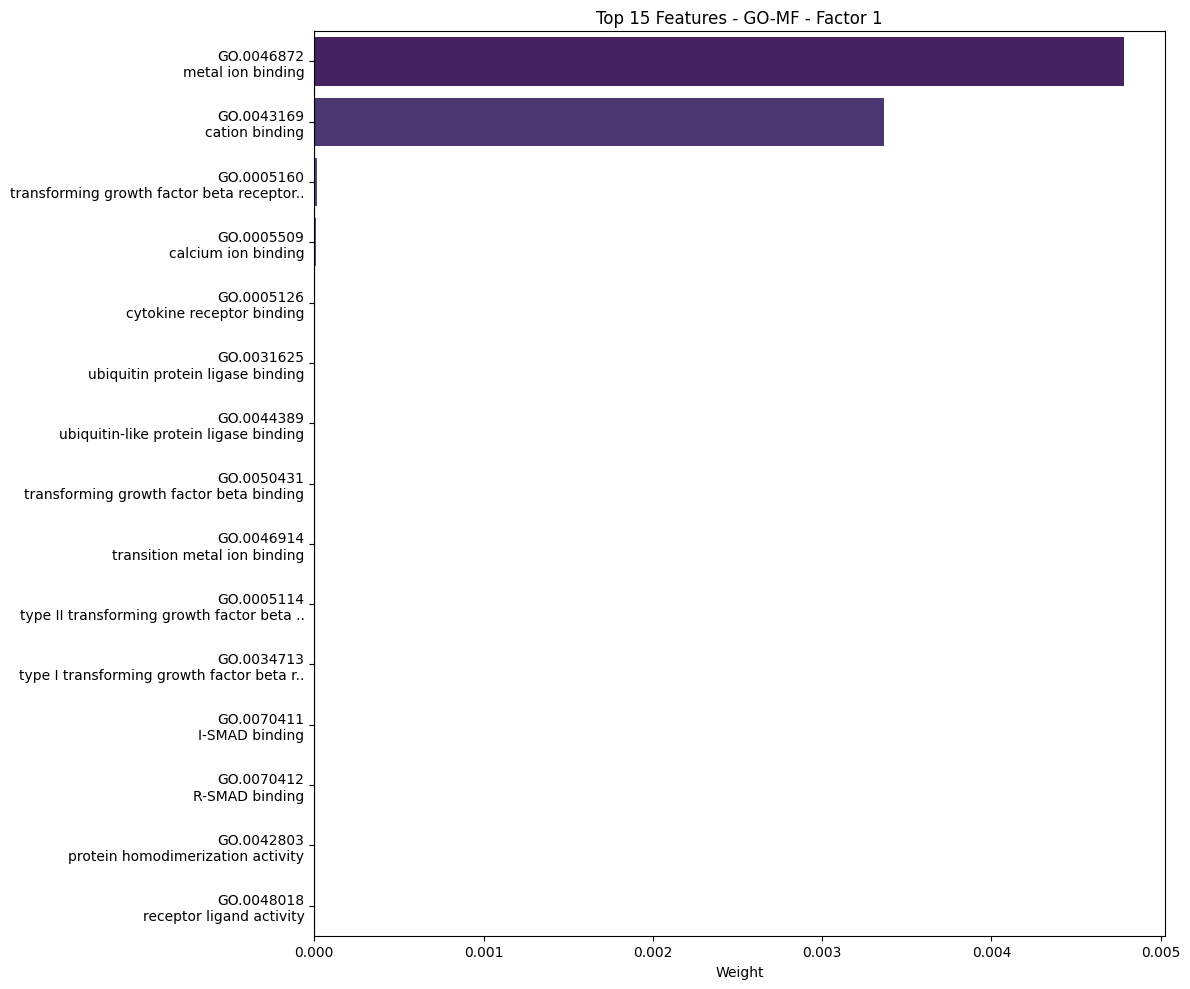

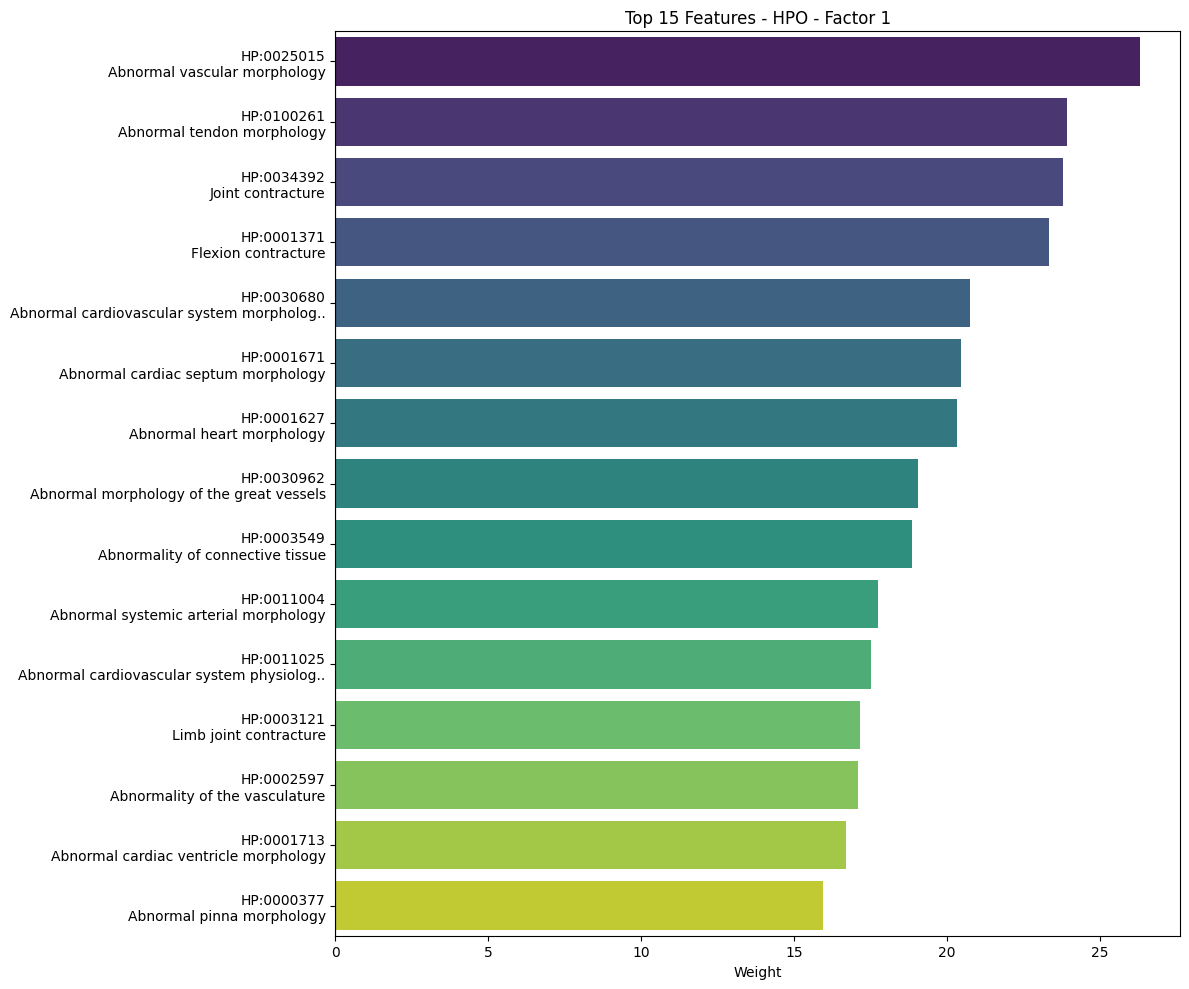

In [97]:
viste_nel_modello = model.views
for vista in viste_nel_modello:
    plot_weights_fixed_translated(vista, factor_index=0)

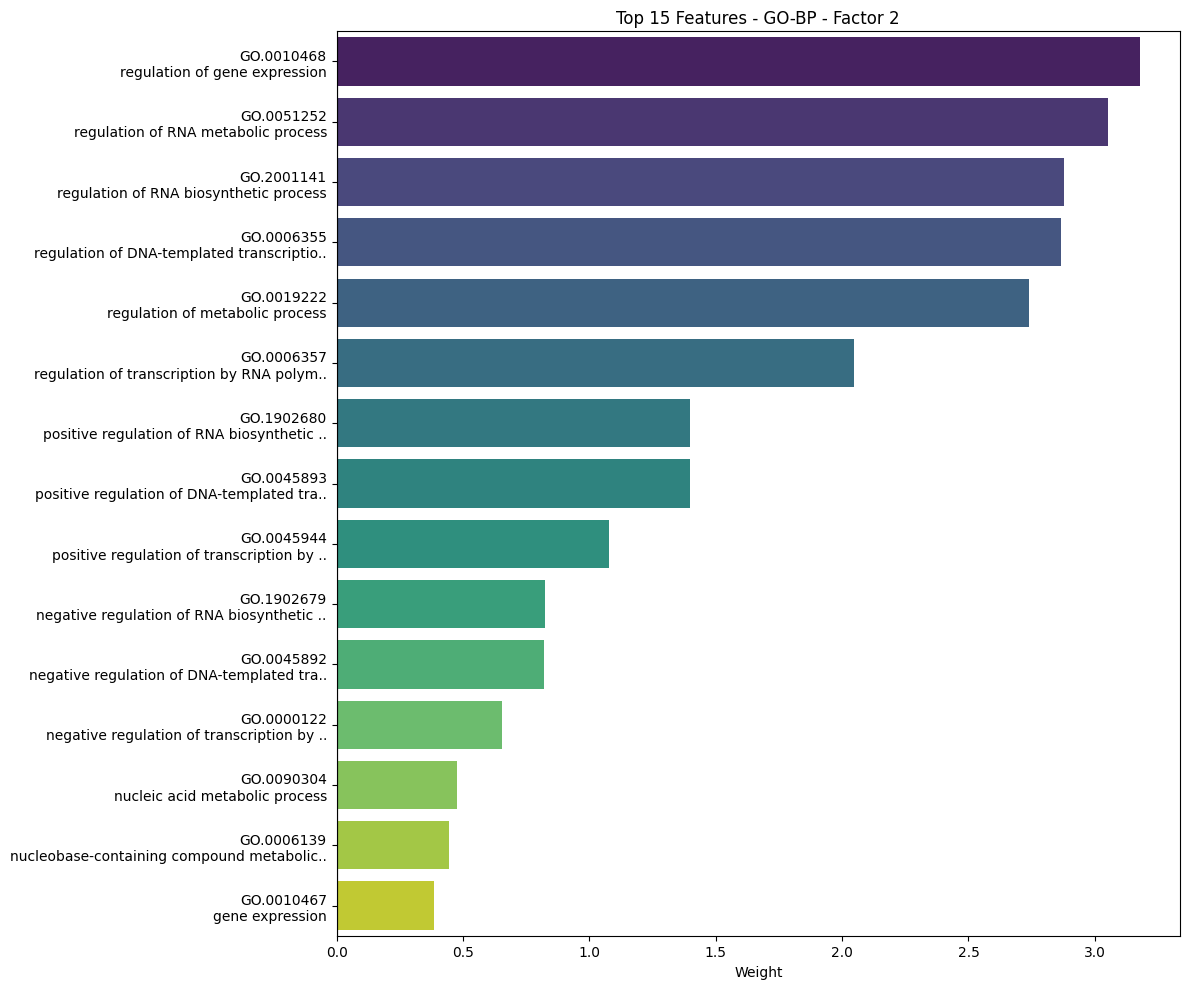

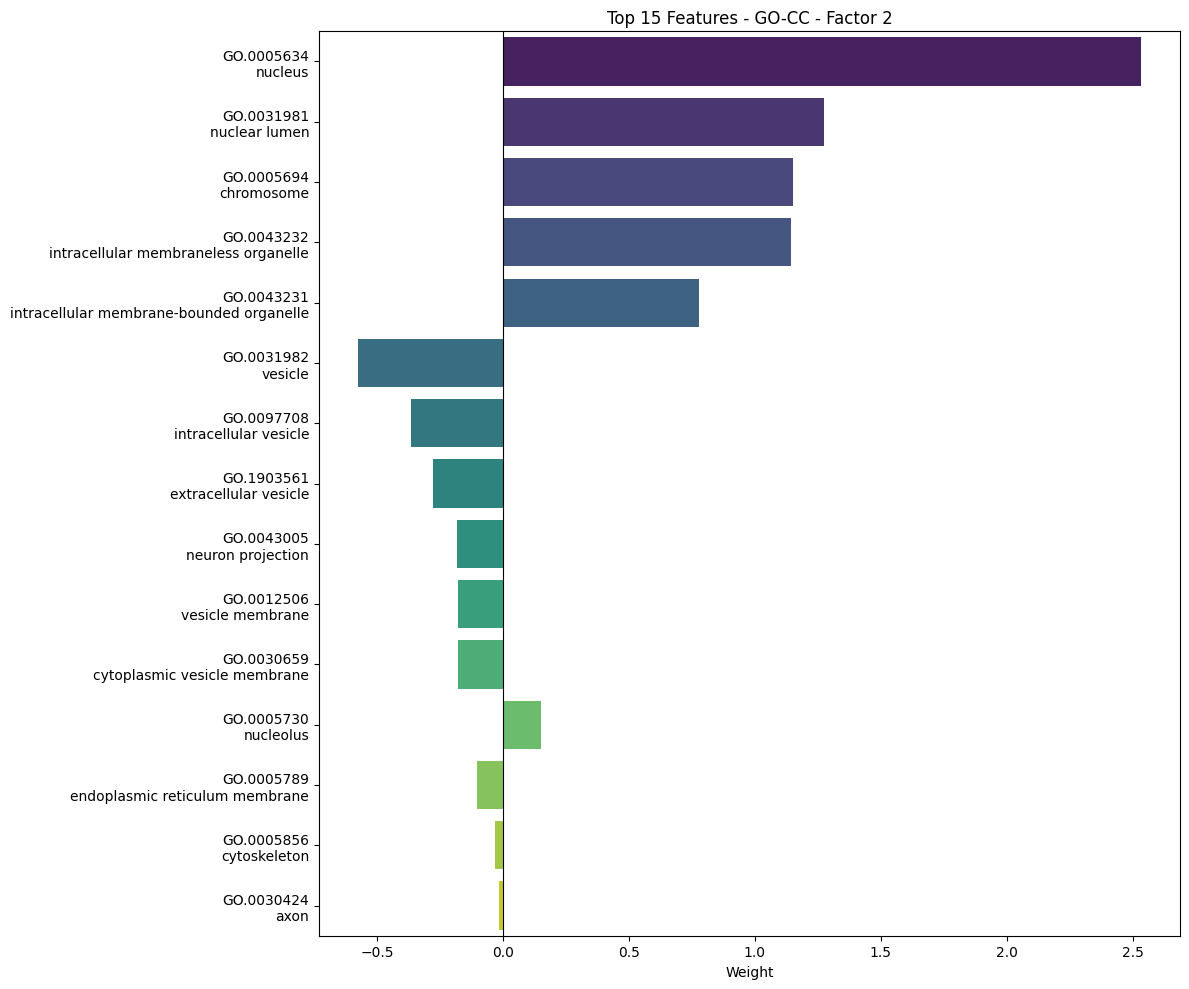

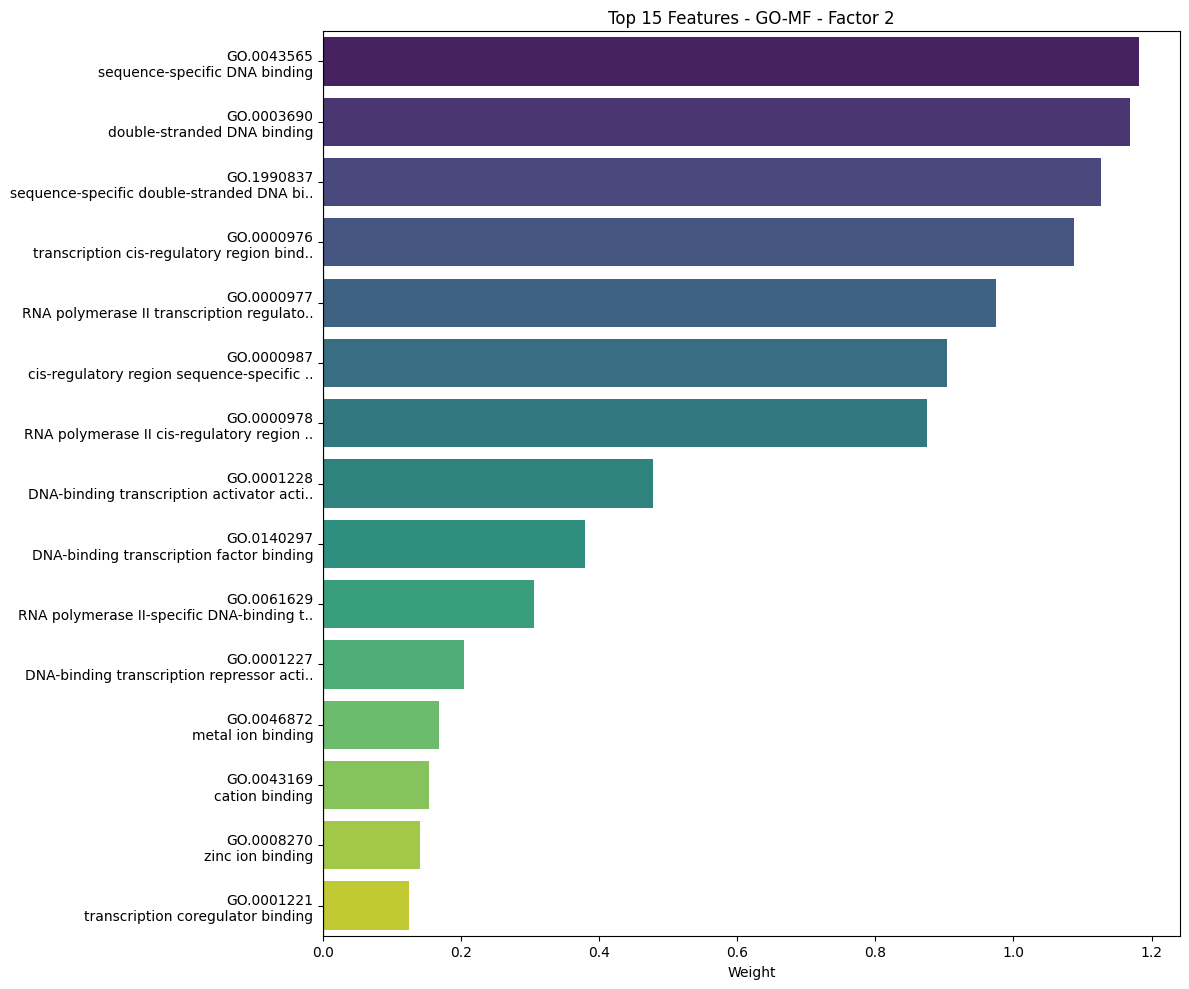

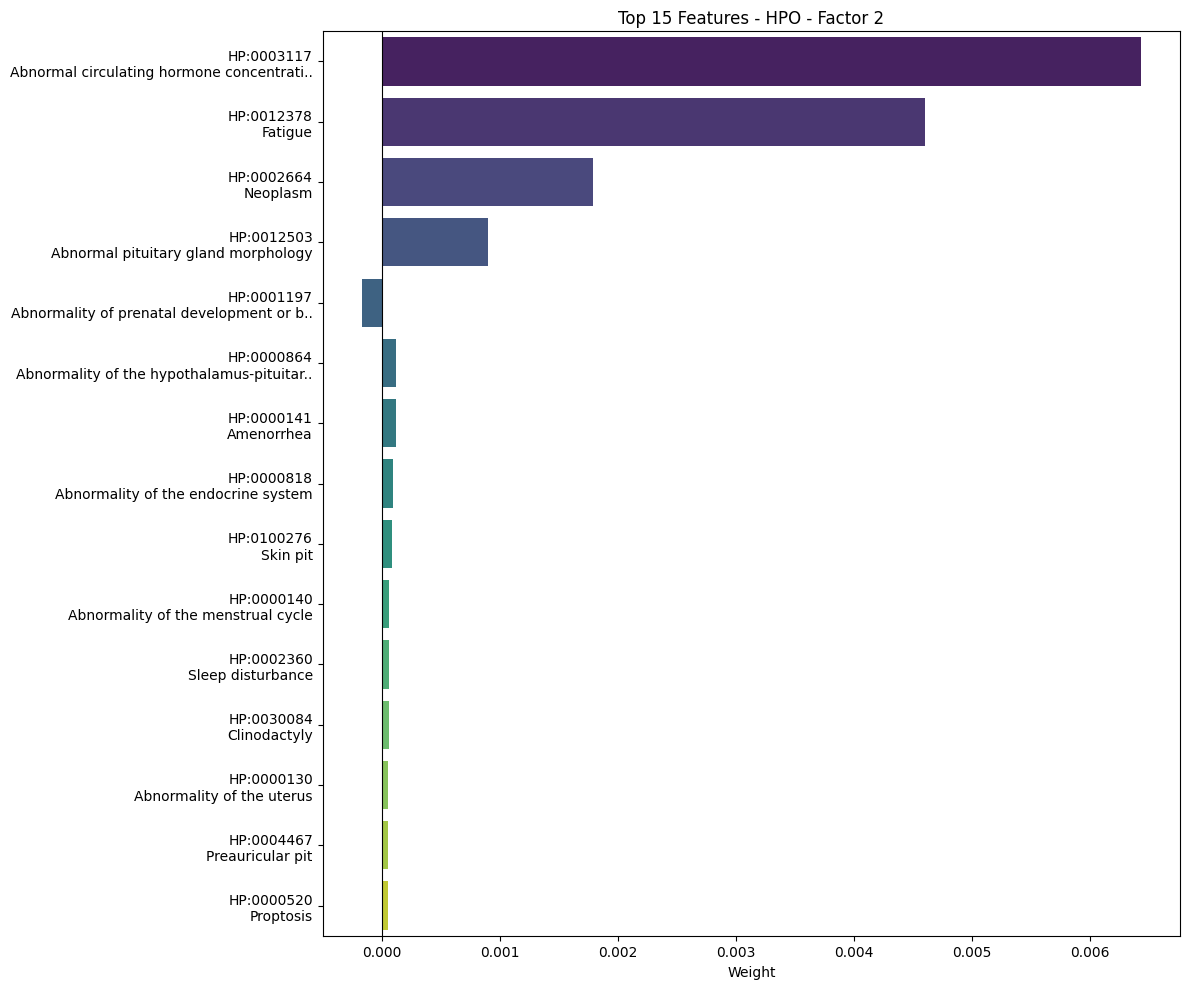

In [98]:
for vista in viste_nel_modello:
    plot_weights_fixed_translated(vista, factor_index=1)

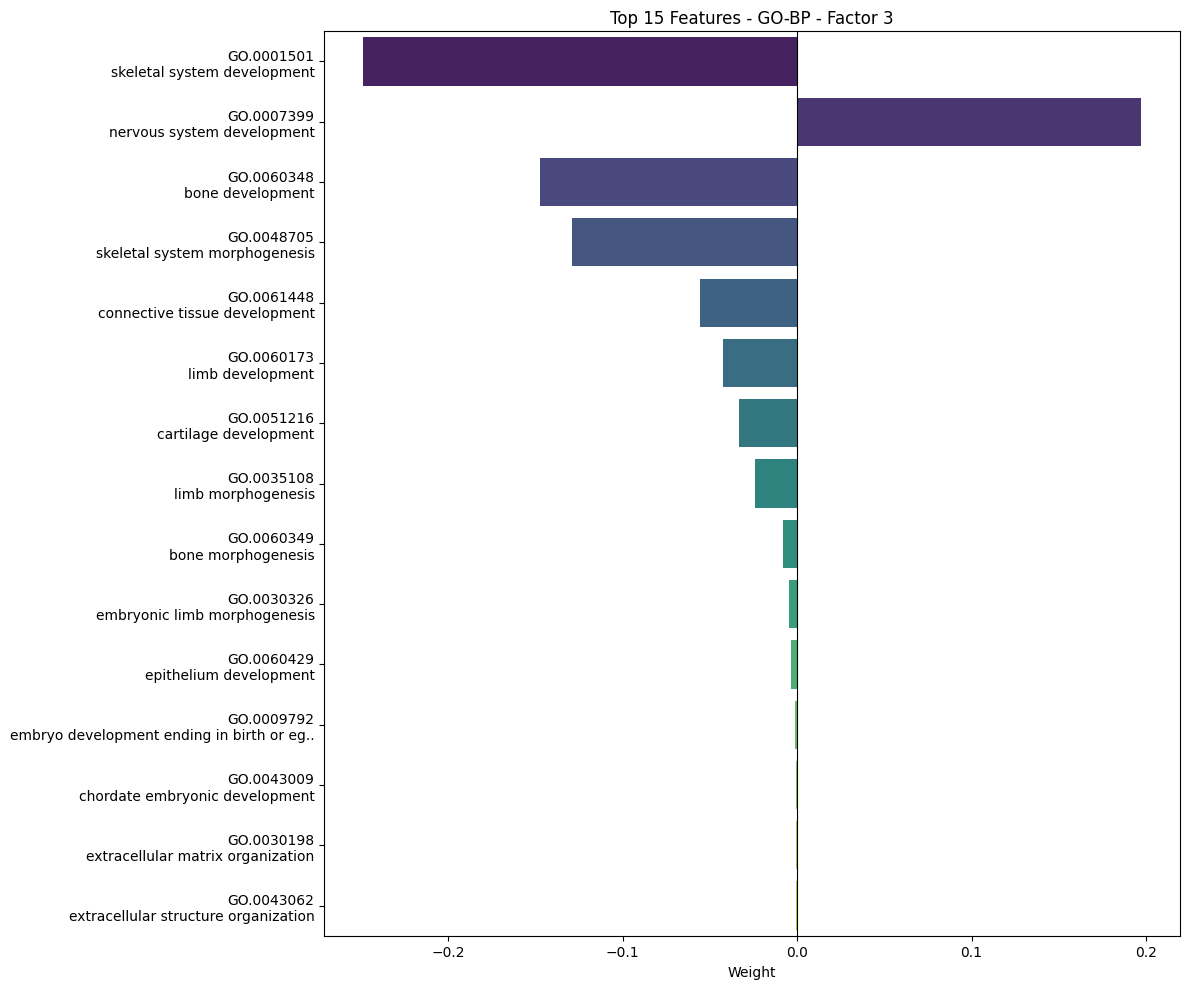

Error fetching description for GO:0043202


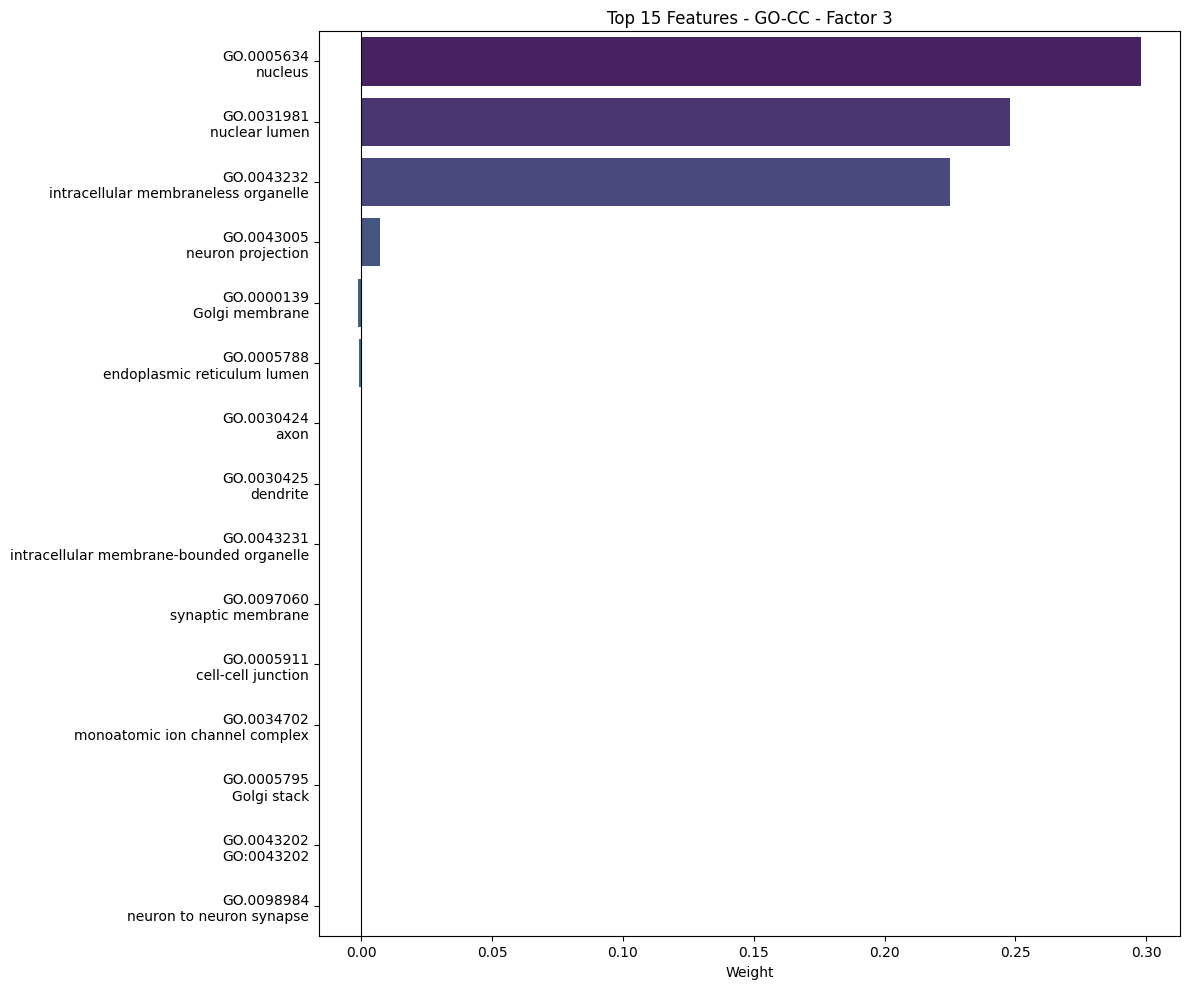

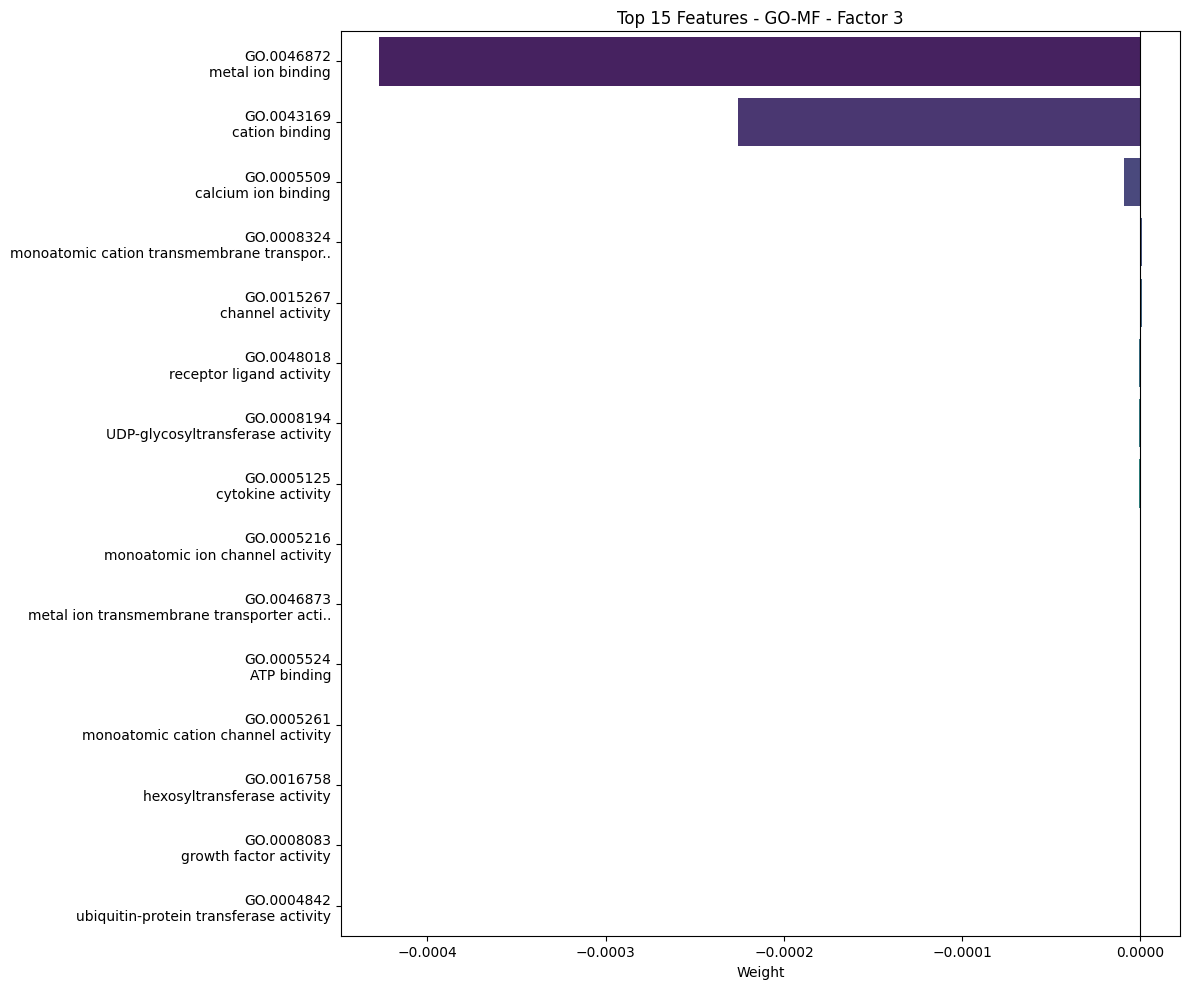

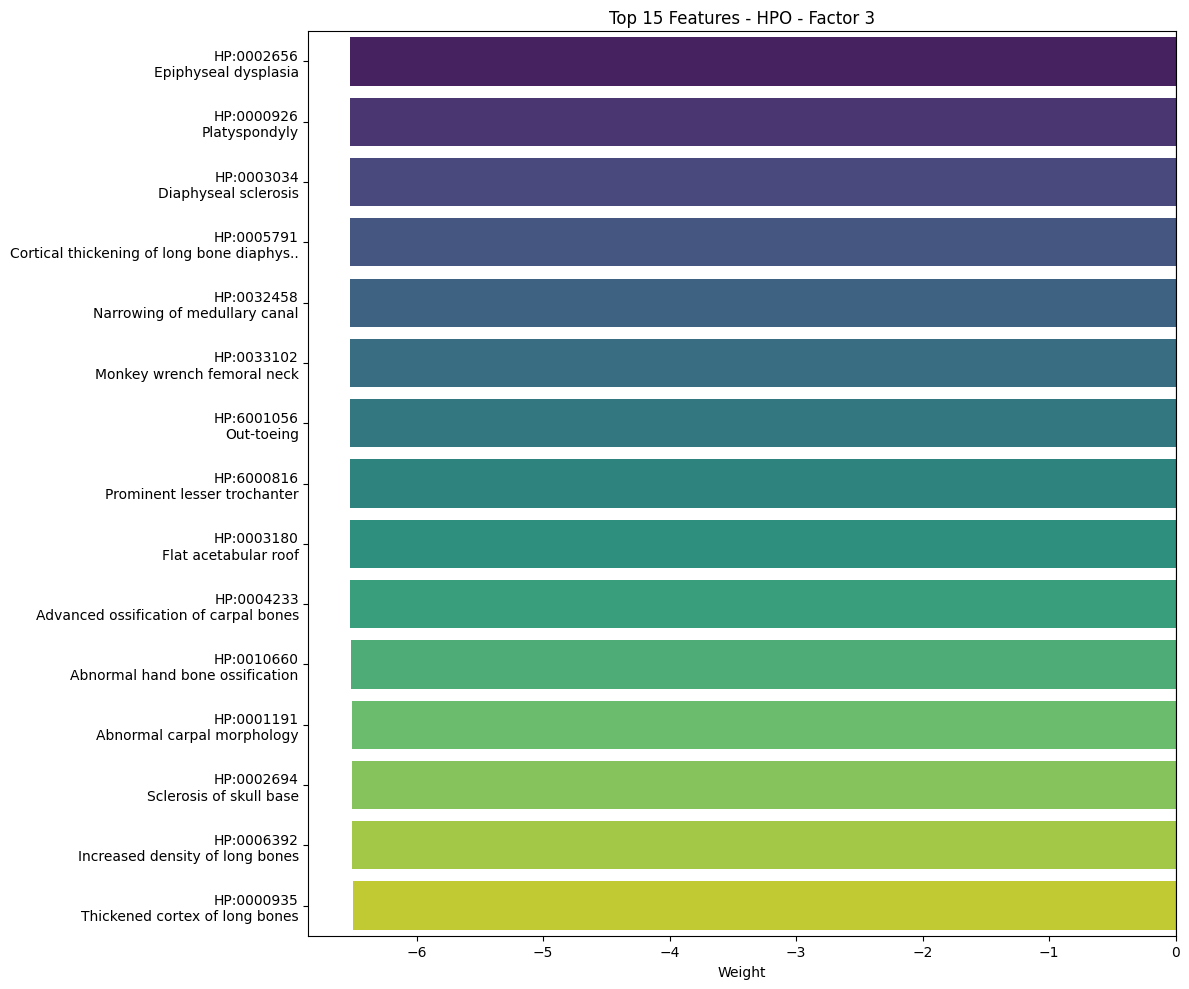

In [99]:
for vista in viste_nel_modello:
    plot_weights_fixed_translated(vista, factor_index=2)

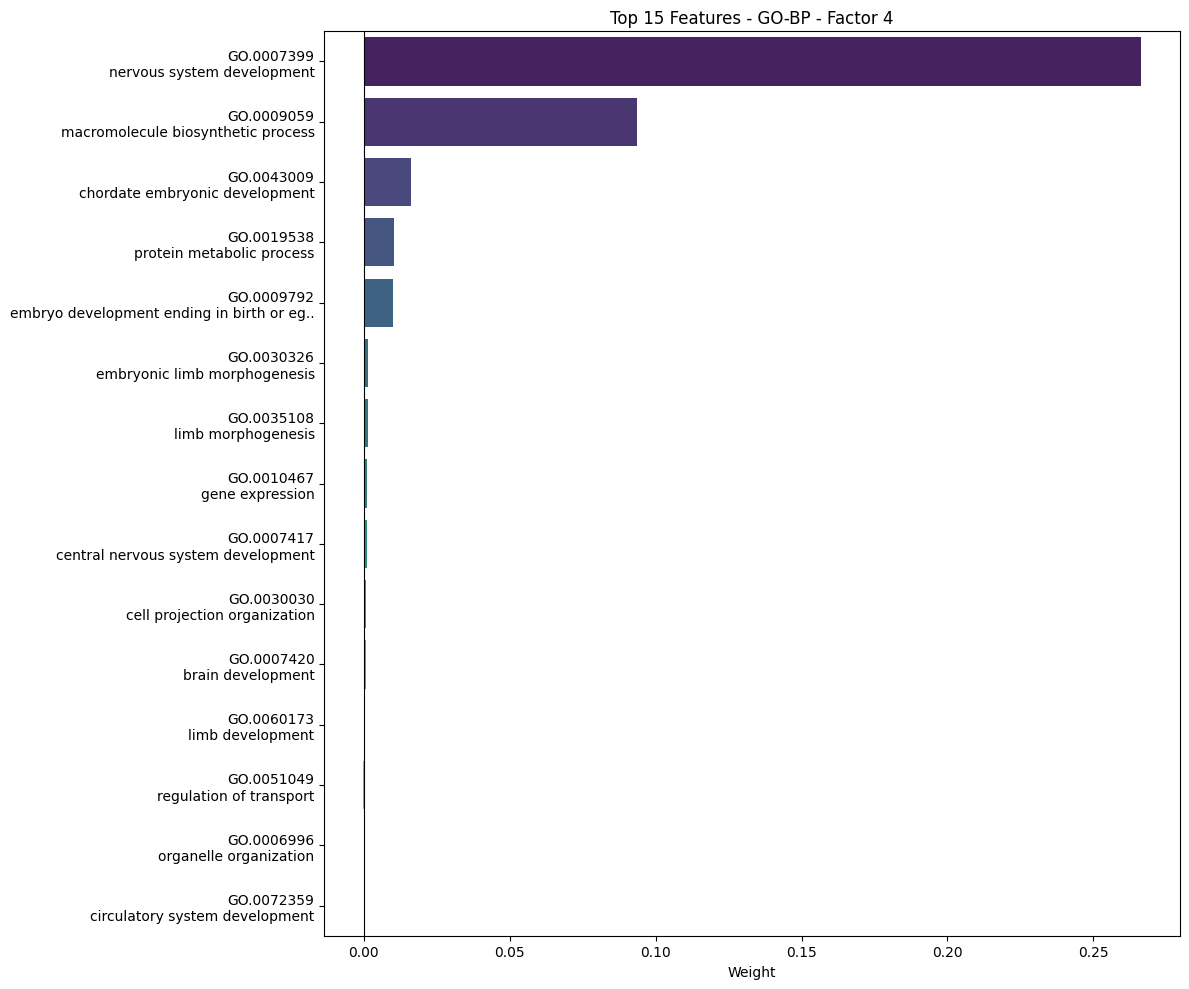

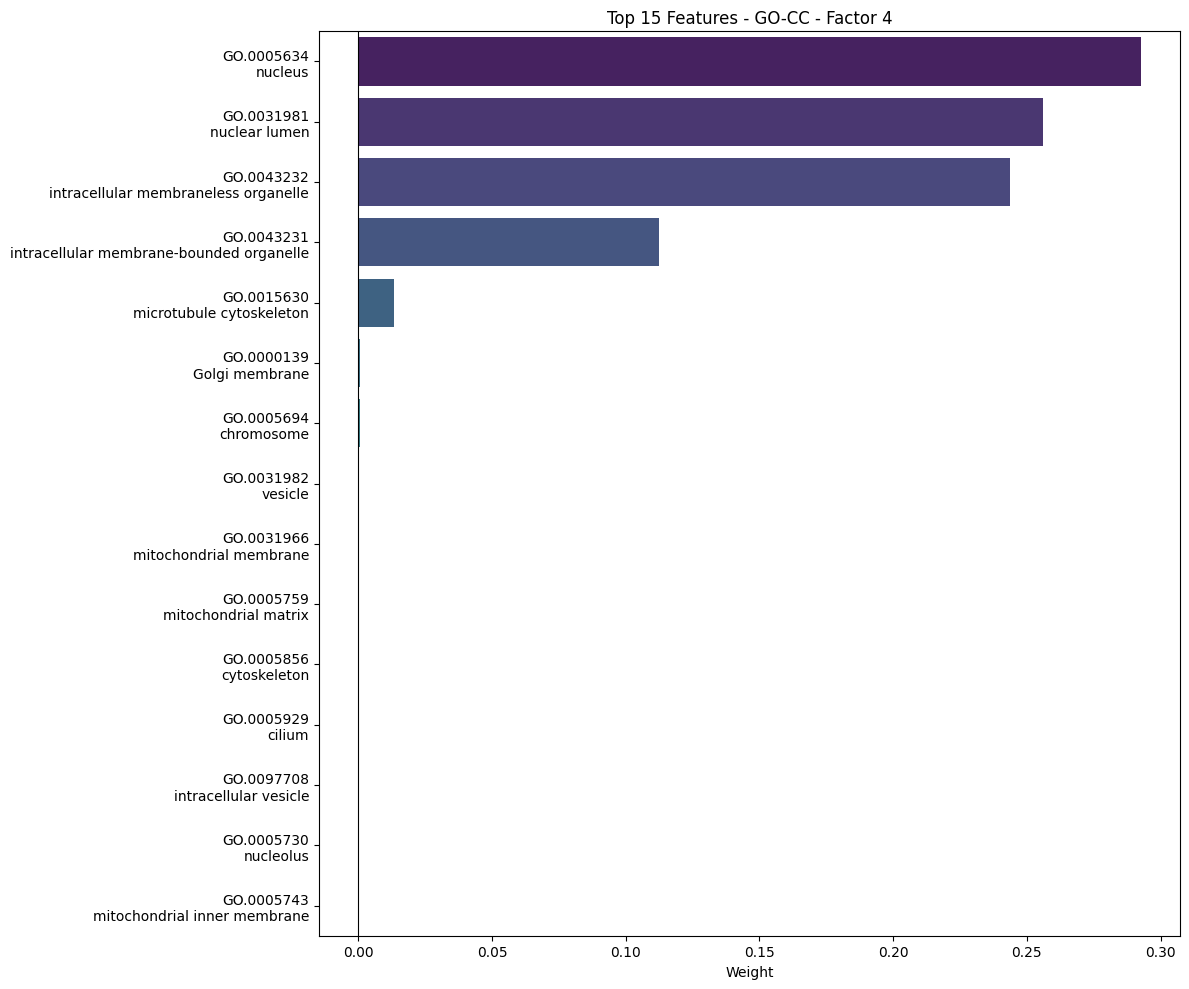

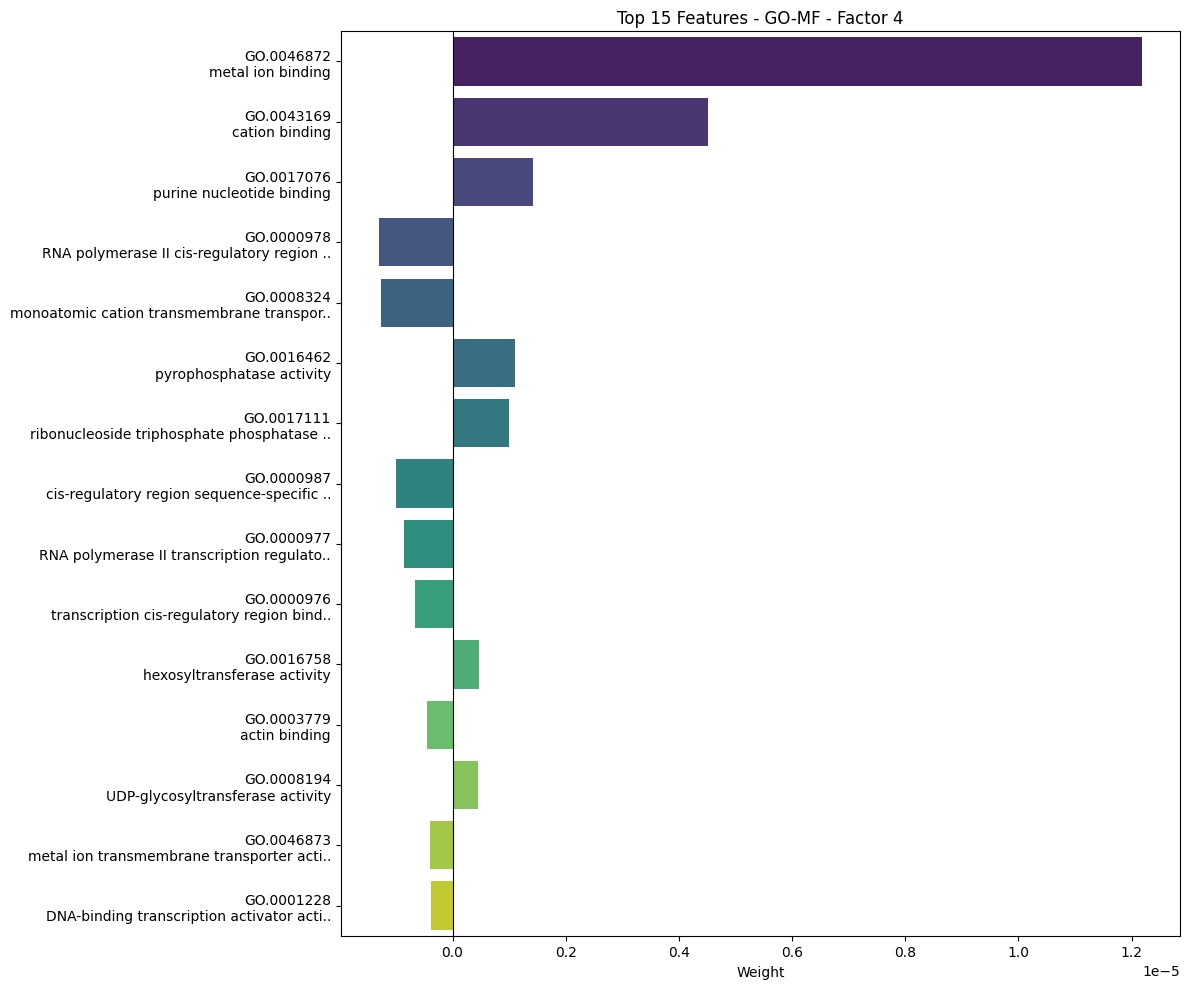

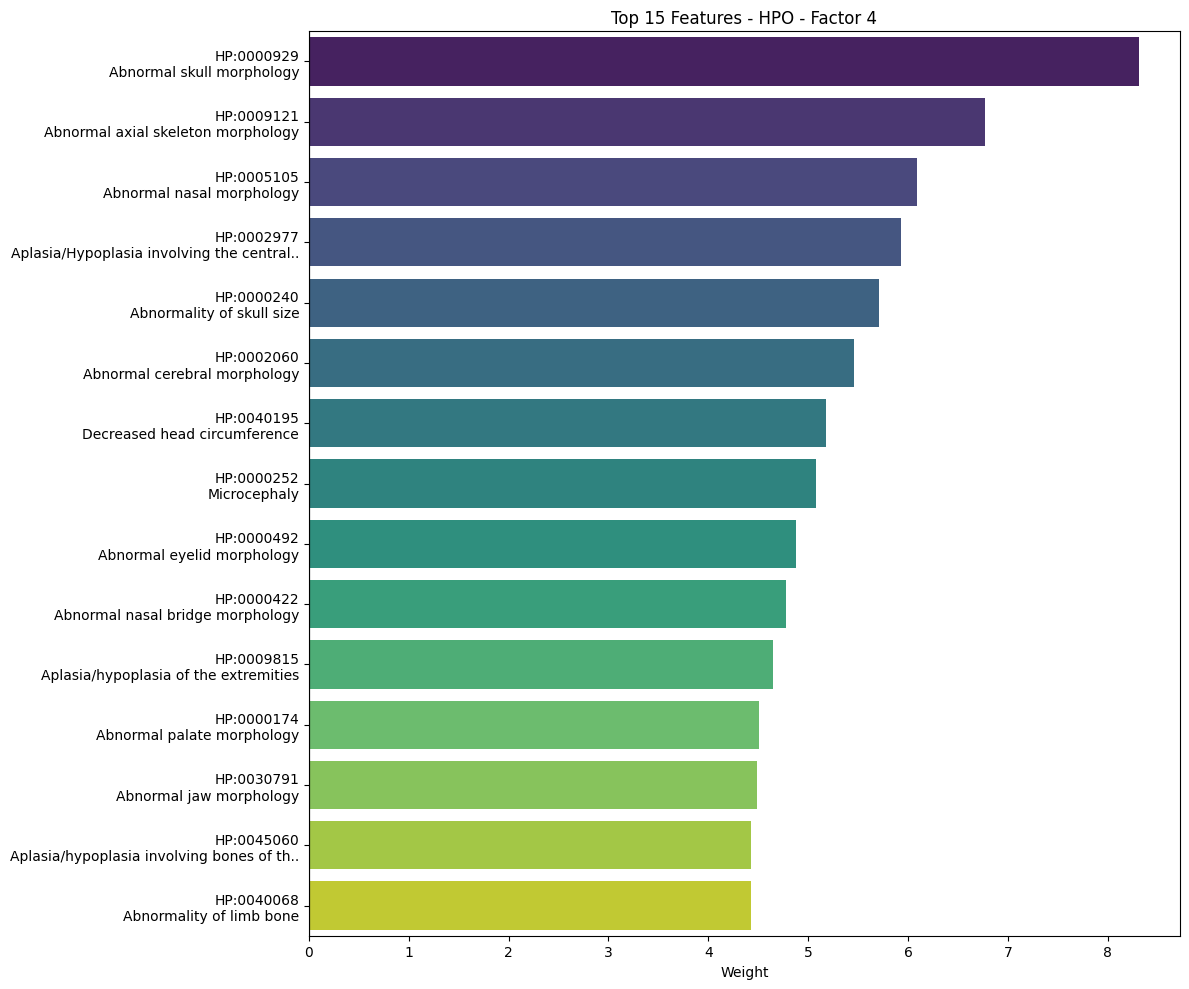

In [101]:
for vista in viste_nel_modello:
    plot_weights_fixed_translated(vista, factor_index=3)

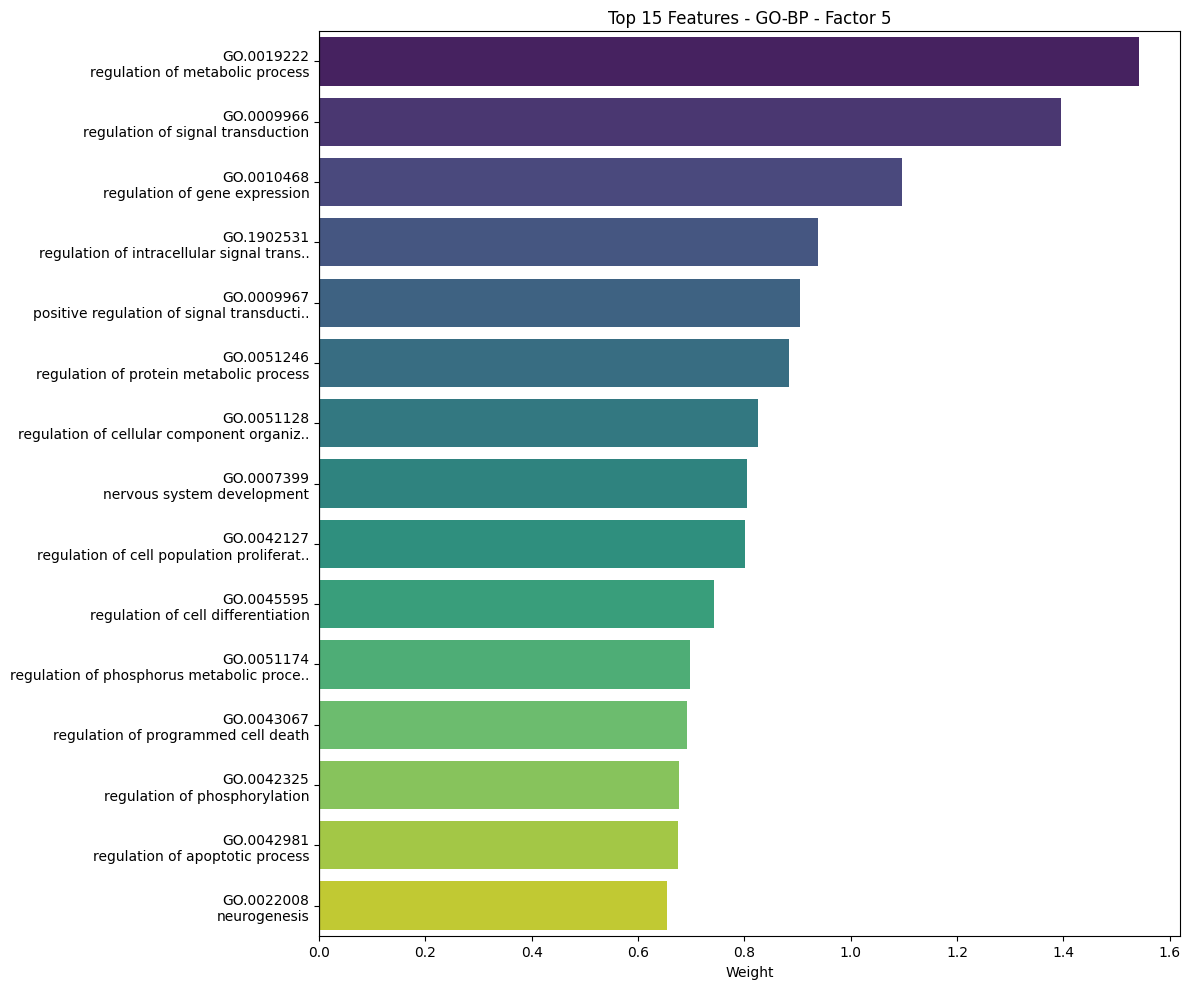

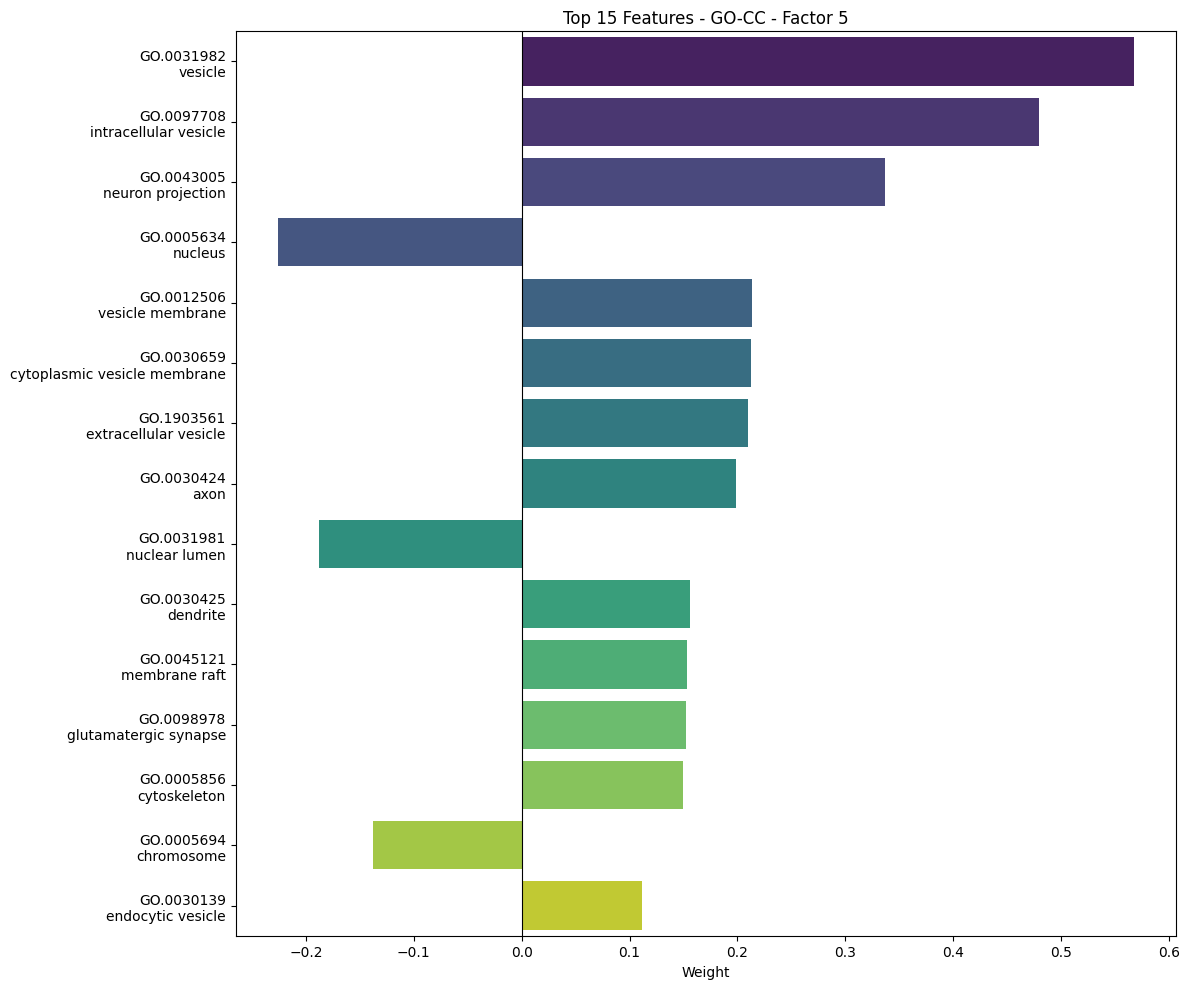

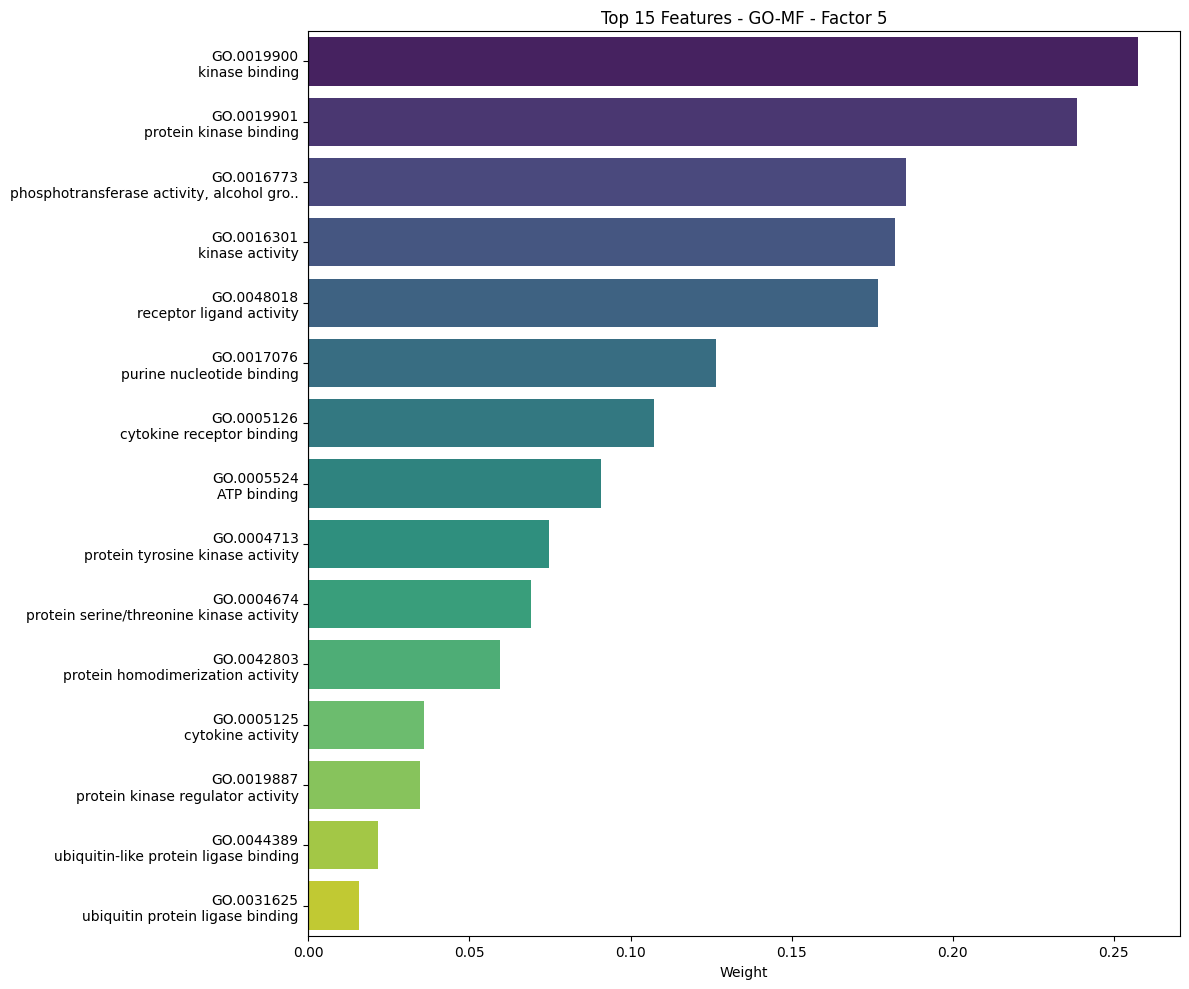

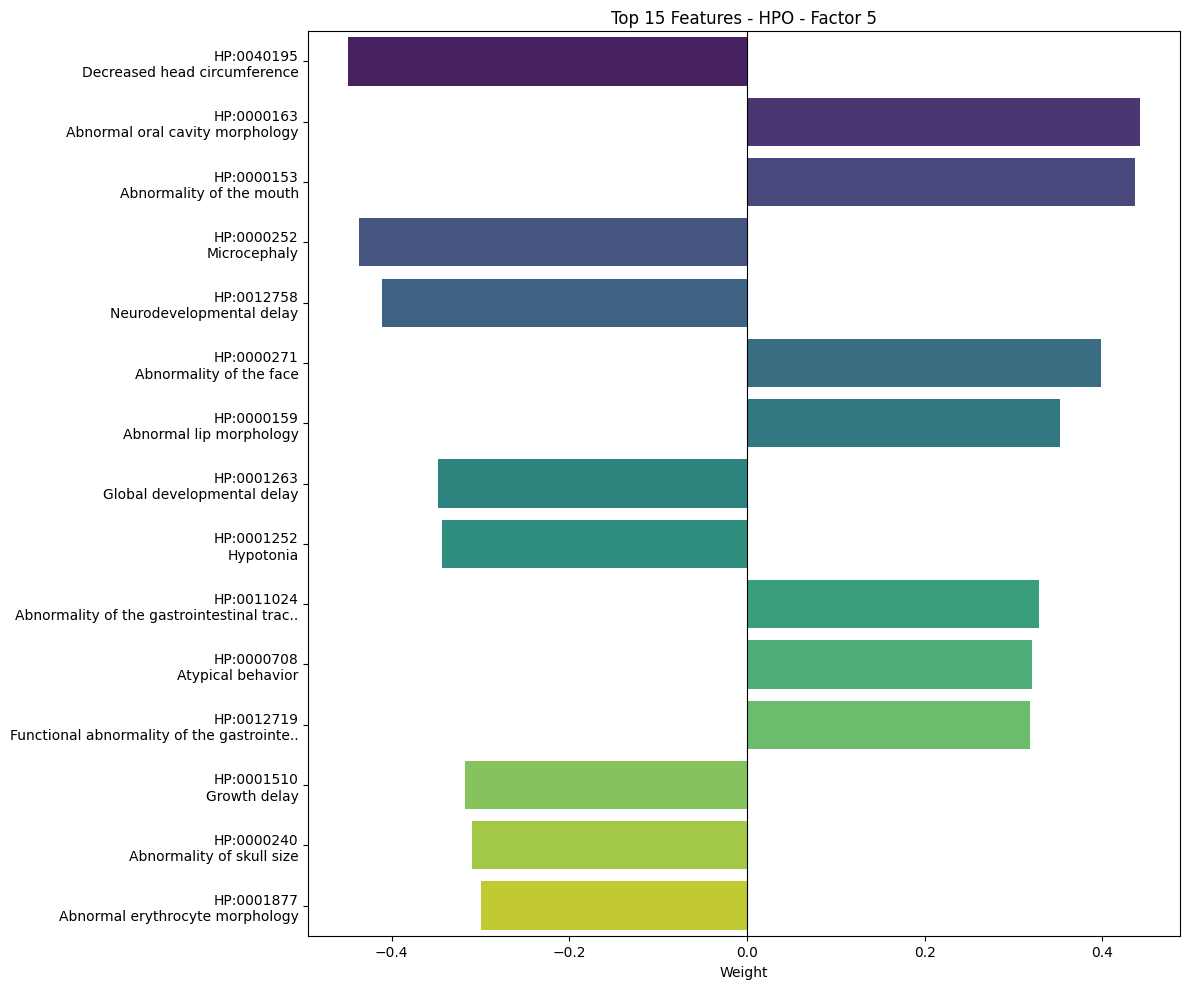

In [102]:
for vista in viste_nel_modello:
    plot_weights_fixed_translated(vista, factor_index=4)

In [112]:
def plot_all_views_aggregated(factor_index=0, n_top=15):
    """
    Cicla su tutte le view in file_paths, unisce i pesi, 
    ordina per valore assoluto globale e plotta i top N.
    """
    
    all_weights_list = []
    
    for view_name in model.views:
        
        # Load Weights
        try:

            w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
        except Exception as e:
            print(f"Skipping {view_name}: Error loading weights ({e})")
            continue

        try:
            if view_name in file_paths:
                csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
                
                if len(csv_cols) == len(w_df):
                    w_df.index = csv_cols
                else:
                    print(f"Warning: Column count mismatch for {view_name}. Keeping generic IDs.")
        except Exception as e:
            print(f"Error reading CSV for {view_name}: {e}")

        # --- Normalizza il nome della colonna dei pesi ---
        # Cerca la colonna numerica (il peso)
        val_col = None
        for c in w_df.columns:
            if pd.api.types.is_numeric_dtype(w_df[c]):
                val_col = c
                break
        
        if val_col is None:
            continue

        # Rinomina la colonna valore in 'weight' per poter concatenare tutto dopo
        w_df = w_df.rename(columns={val_col: 'weight'})
        
        # Aggiunge colonna per tracciare la provenienza (es. 'mRNA', 'Methylation')
        w_df['view'] = view_name
        
        # Salviamo l'ID originale (il nome del gene/feature)
        w_df['feature_id'] = w_df.index
        
        all_weights_list.append(w_df[['weight', 'view', 'feature_id']])

    if not all_weights_list:
        print("Nessun peso caricato.")
        return

    combined_df = pd.concat(all_weights_list, axis=0)

    # --- Ordinamento Globale ---
    combined_df['abs_val'] = combined_df['weight'].abs()
    top_features = combined_df.sort_values('abs_val', ascending=False).head(n_top)

    # --- Creazione Etichette (Translation) ---
    new_labels = []
    for _, row in top_features.iterrows():
        term_id = row['feature_id']
        view_source = row['view']
        
        # Chiama la tua funzione di traduzione esterna
        try:
            desc = get_term_description(term_id)
        except:
            desc = term_id
            
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features['plot_label'] = new_labels

    plt.figure(figsize=(12, 10 + (n_top // 5)))
    
    sns.barplot(
        data=top_features,
        x='weight',
        y='plot_label',
        hue='view',
        dodge=False,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Global Features - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.legend(title='View Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

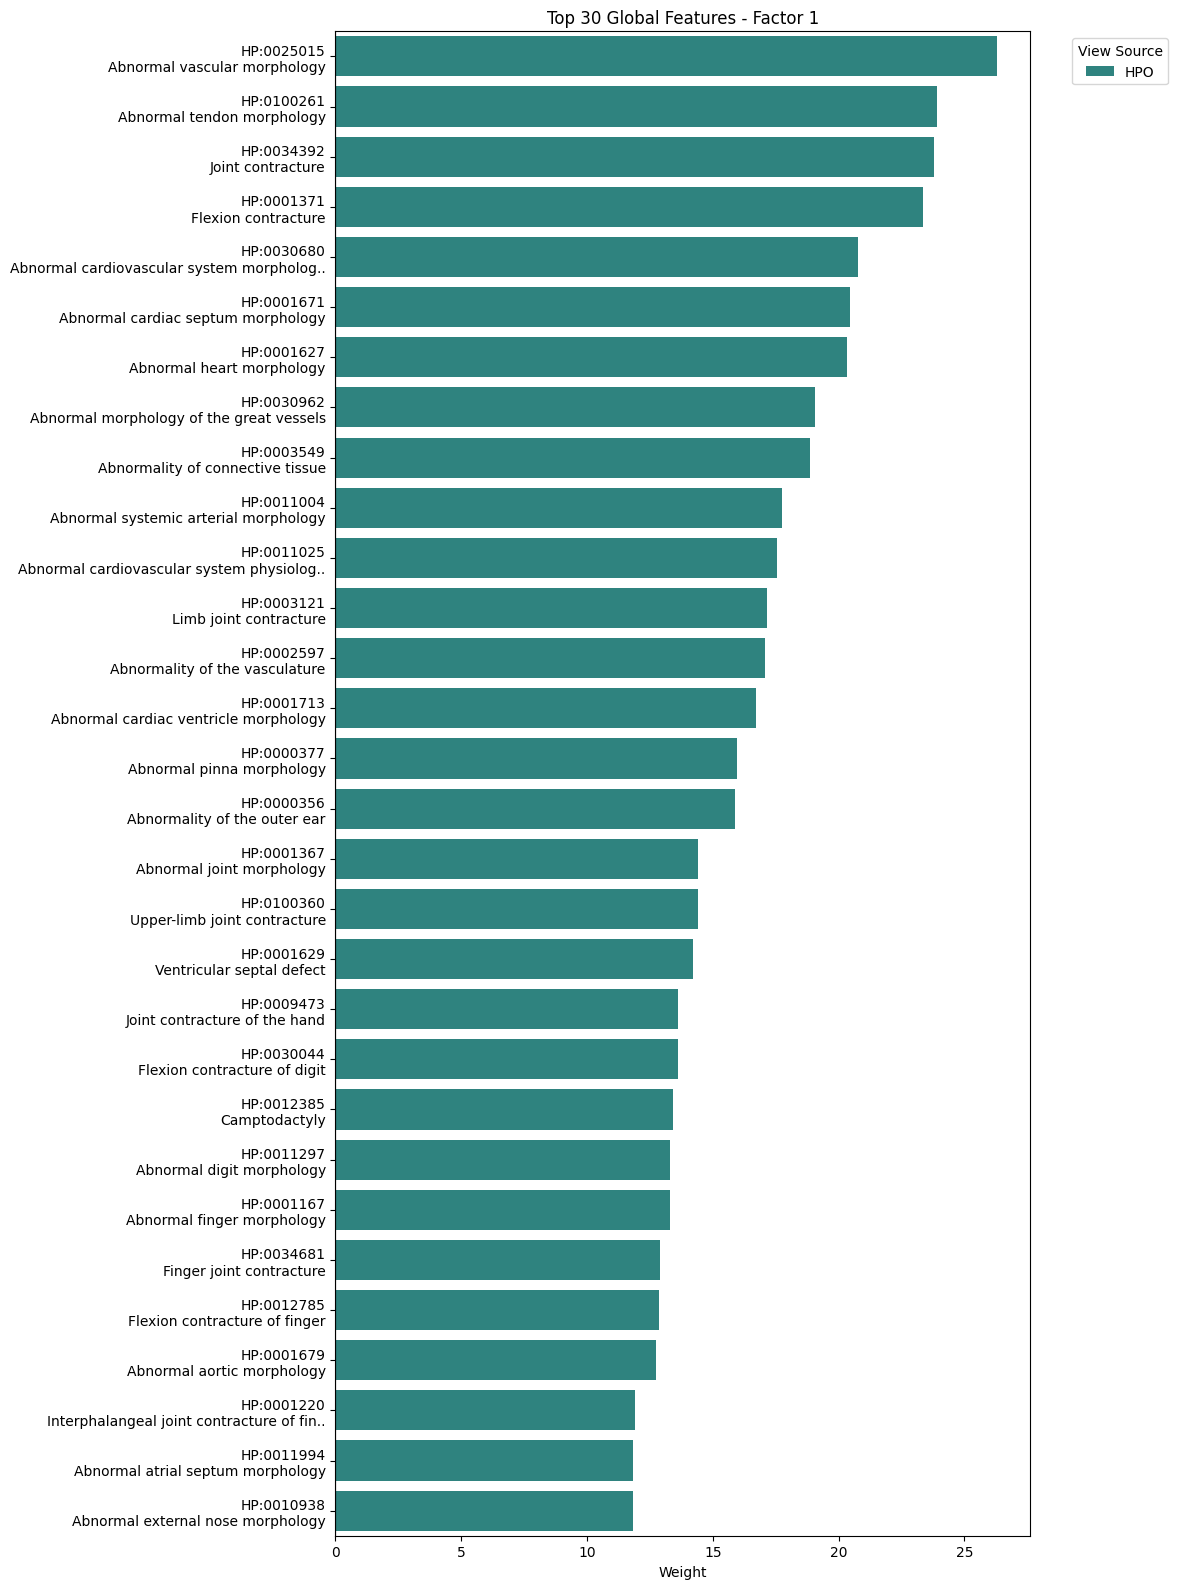

Error fetching description for GO:0000978


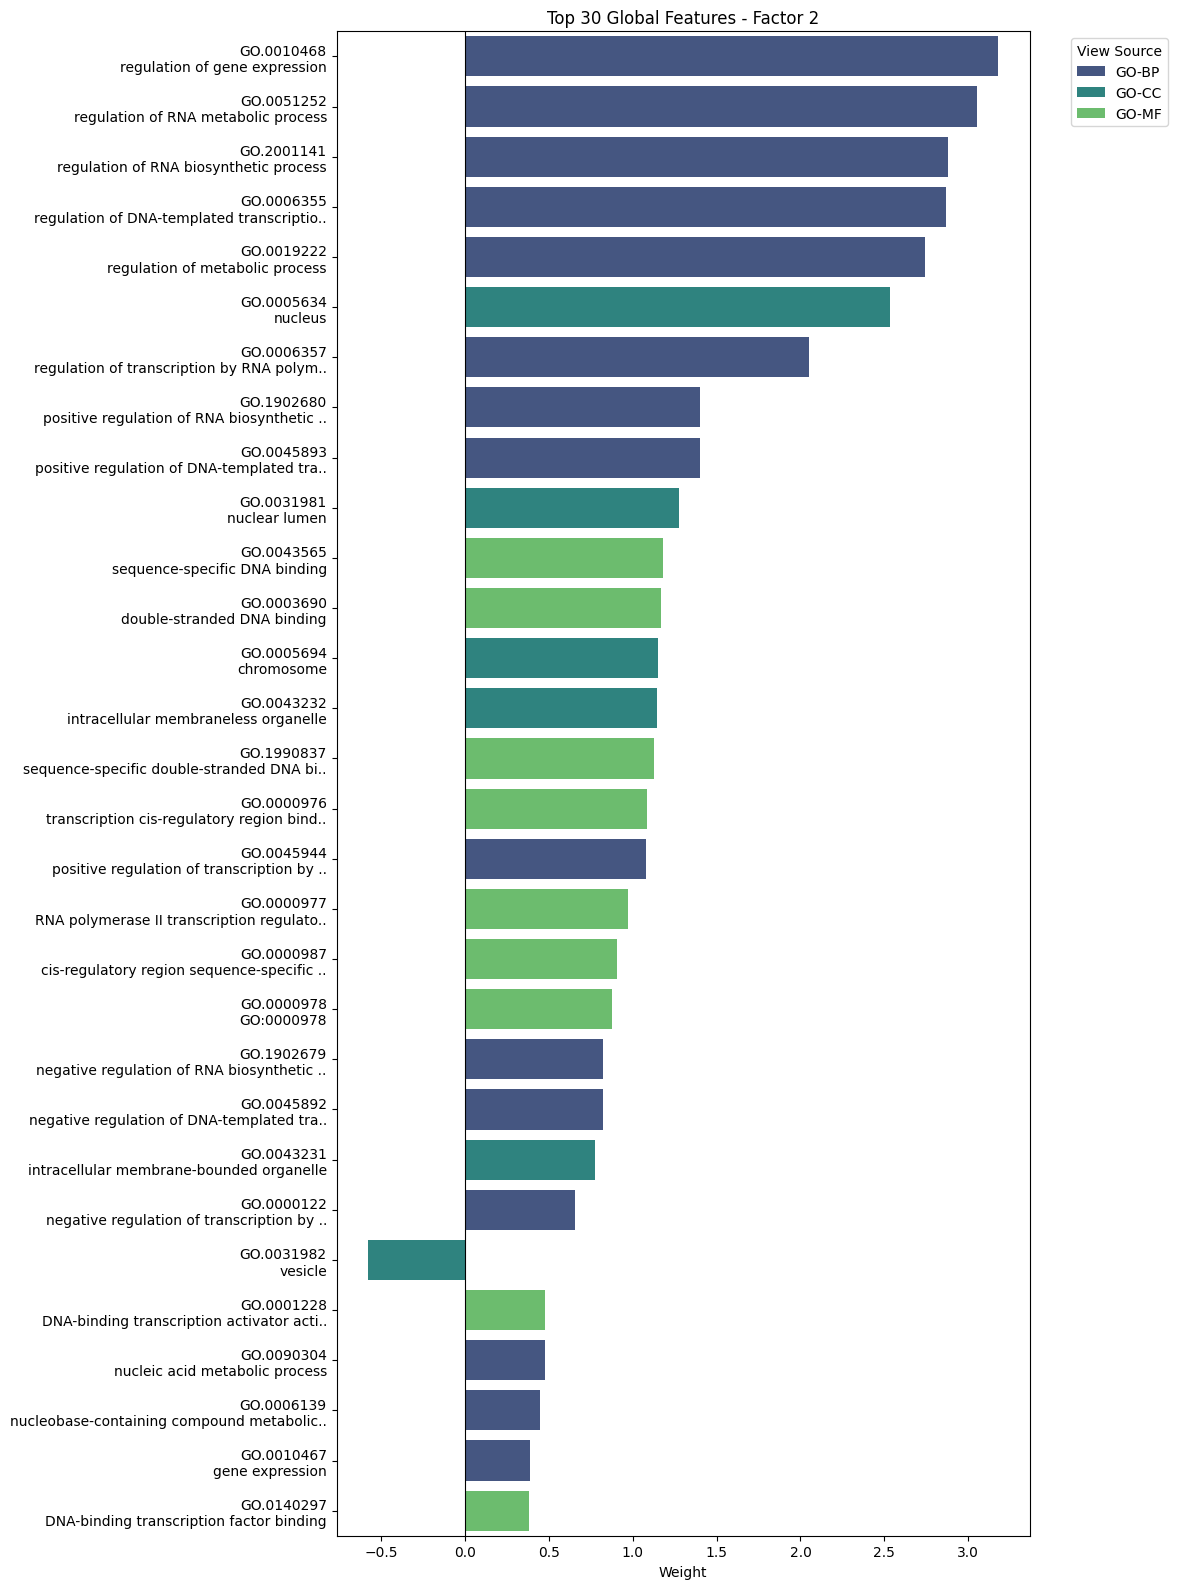

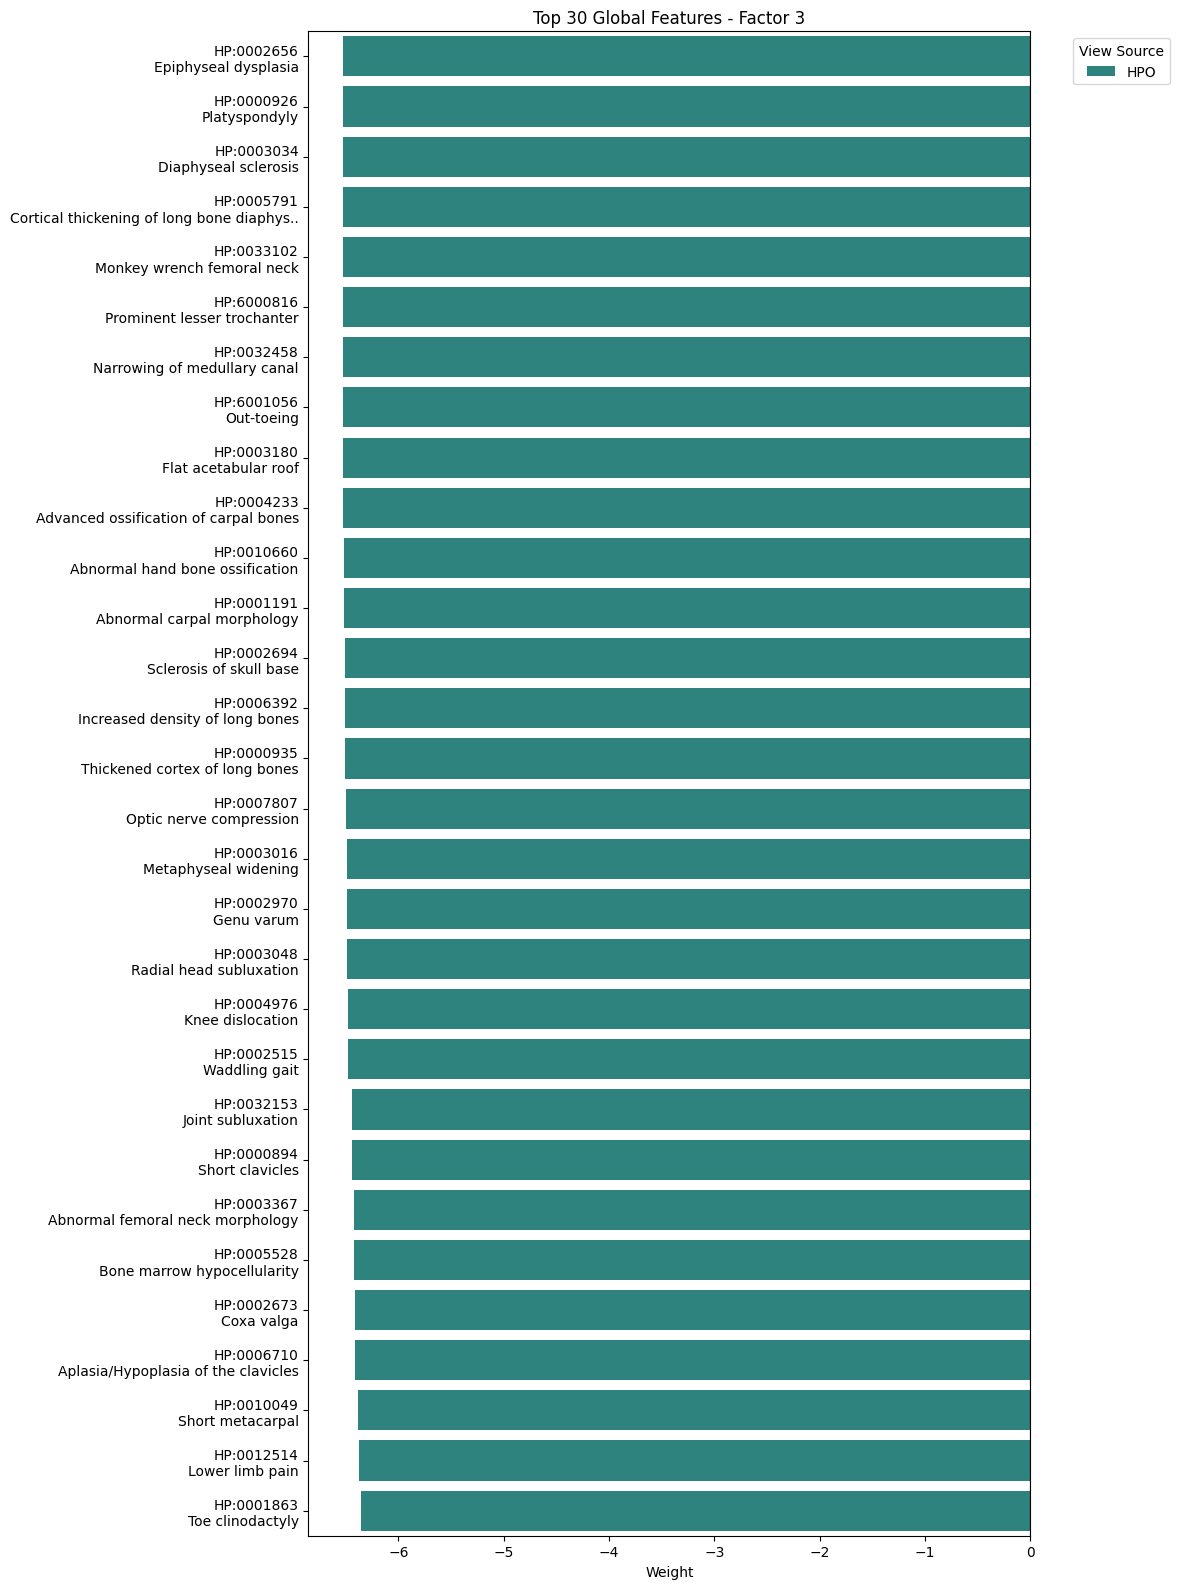

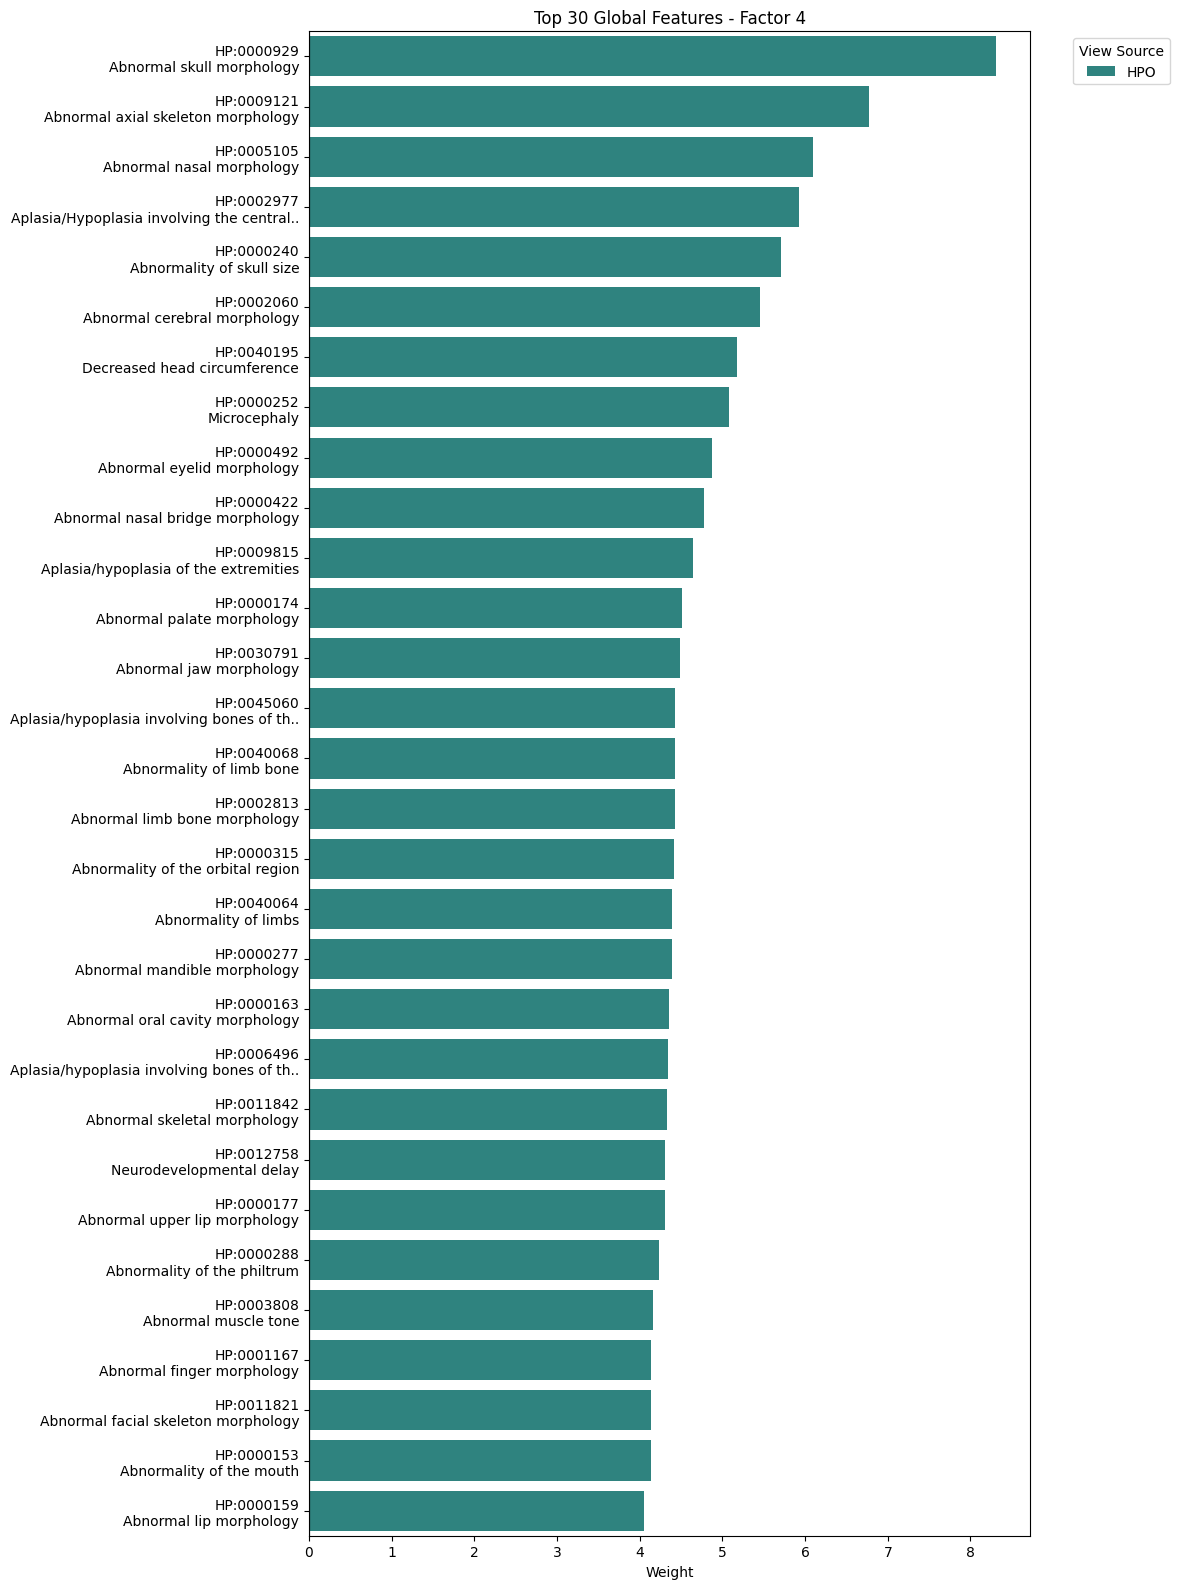

Error fetching description for GO:0031982
Error fetching description for GO:2000145


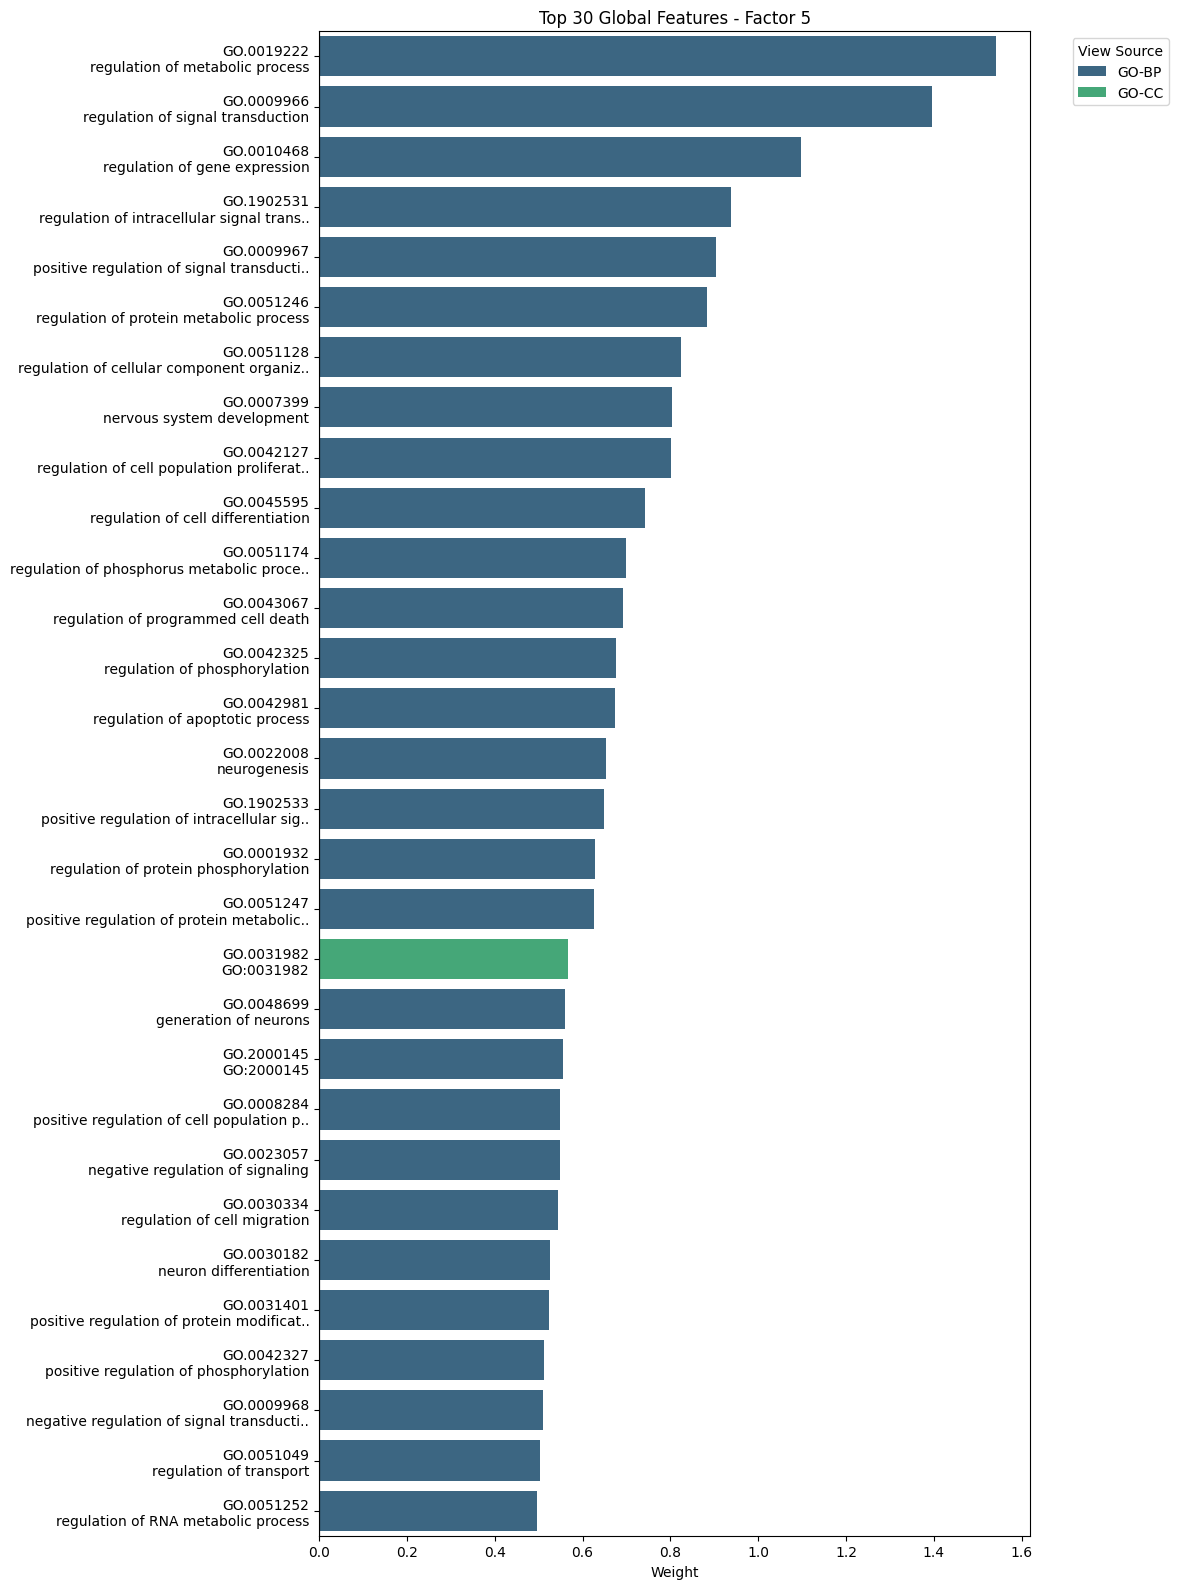

In [113]:
for factor_idx in range(5):
    plot_all_views_aggregated(factor_index=factor_idx, n_top=30)

<Axes: title={'center': 'GO-BP'}, xlabel='Feature weight'>

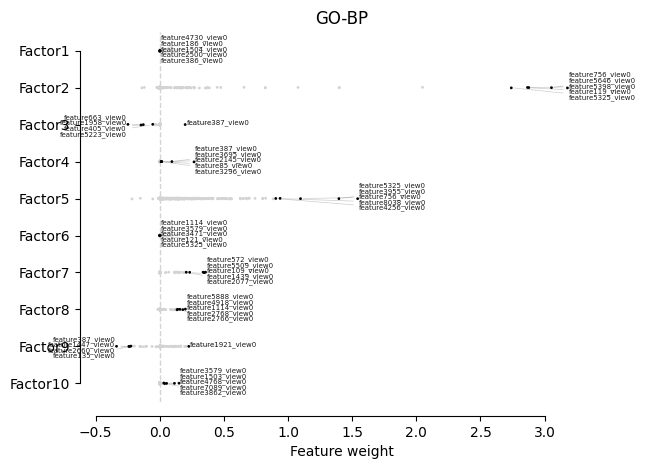

In [49]:
from mofax import plot_weights, plot_weights_correlation, plot_weights_ranked, plot_weights_scaled
plot_weights(model, views='GO-BP',n_top=5)

Running K-Means with 3 clusters...


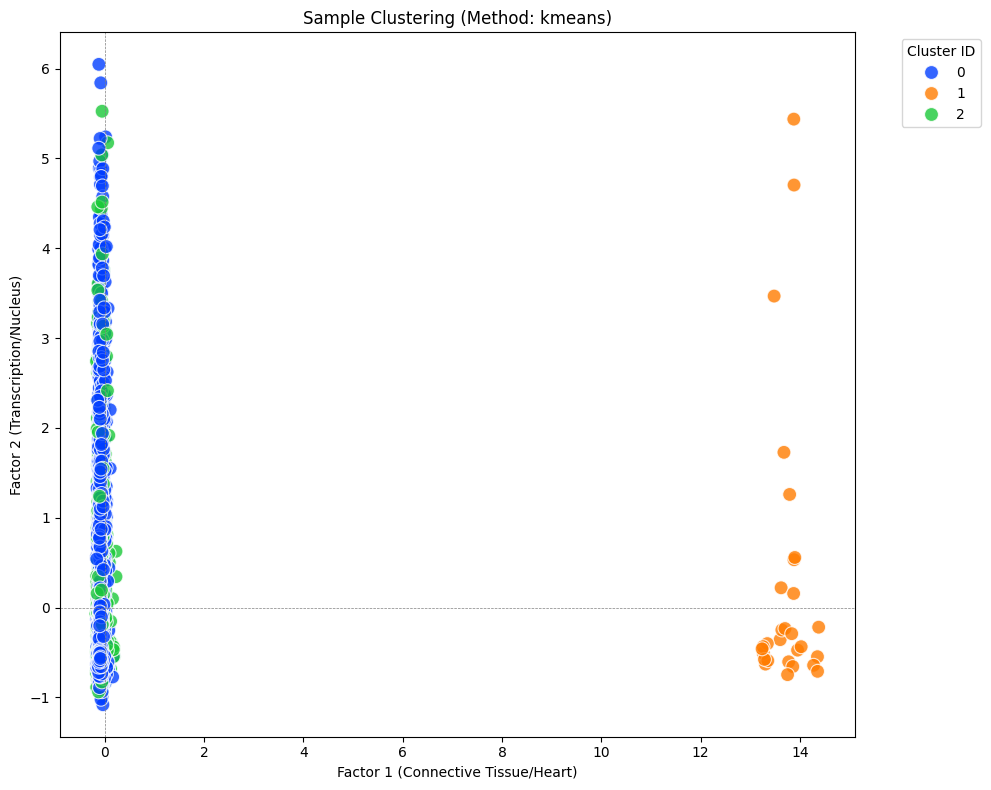

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering

def run_clustering_analysis(n_clusters=3, method='kmeans'):
    """
    1. Gets the Latent Factors (Z matrix) for samples.
    2. Clusters the samples.
    3. Plots Factor 1 vs Factor 2 colored by Cluster.
    """
    
    # --- 1. Get Latent Factors (Z Matrix) ---
    # This matrix is (Samples x Factors). 
    # It represents where each patient sits in the "MOFA space".
    z_df = model.get_factors(df=True)
    
    # We usually cluster on ALL factors (or the top significant ones)
    # to get the most accurate groups.
    X = z_df.values 

    # --- 2. Clustering ---
    if method == 'kmeans':
        print(f"Running K-Means with {n_clusters} clusters...")
        clustering = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = clustering.fit_predict(X)
        
    elif method == 'spectral':
        print(f"Running Spectral Clustering with {n_clusters} clusters...")
        # assign_labels='discretize' is often more stable
        clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=42)
        labels = clustering.fit_predict(X)
        
    else:
        print("Method not supported. Use 'kmeans' or 'spectral'.")
        return

    # Add cluster labels to dataframe
    z_df['Cluster'] = labels.astype(str) # String for categorical coloring

    # --- 3. Plotting Factor 1 vs Factor 2 ---
    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(
        data=z_df, 
        x='Factor1', 
        y='Factor2', 
        hue='Cluster', 
        palette='bright',
        s=100,      # Dot size
        alpha=0.8   # Transparency
    )
    
    plt.title(f"Sample Clustering (Method: {method})")
    plt.xlabel("Factor 1 (Connective Tissue/Heart)") # Based on your previous analysis
    plt.ylabel("Factor 2 (Transcription/Nucleus)")   # Based on your previous analysis
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return z_df

labeled_data = run_clustering_analysis(n_clusters=3, method='kmeans') 
